# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [22]:
# Import essential libraries for data manipulation and analysis
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [2]:
# Importing the file porter_data_1.csv
file_path = './porter_data_1.csv'
porter_df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to verify successful loading
porter_df.head()

market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  
0                14.0                      21.0     34.44  
1                 2.0                       2.0     27.60  
2                 6.0                      18.0     11.56  
3                 6.0                       8.0     31.80  
4                 5.0                       7.0      8.20

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [3]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format

porter_df['created_at'] = pd.to_datetime(porter_df['created_at'])
porter_df['actual_delivery_time'] = pd.to_datetime(porter_df['actual_delivery_time'])

# Verify conversion by checking the data types
porter_df.dtypes[['created_at', 'actual_delivery_time']]

created_at              datetime64[ns]
actual_delivery_time    datetime64[ns]
dtype: object

##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [4]:
# Convert categorical features to category type

categorical_columns = ['market_id', 'store_primary_category', 'order_protocol']
porter_df[categorical_columns] = porter_df[categorical_columns].astype('category')

# Verify the conversion by checking the data types
porter_df.dtypes[categorical_columns]

market_id                 category
store_primary_category    category
order_protocol            category
dtype: object

#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [5]:
# Calculate time taken in minutes
porter_df['time_taken_minutes'] = (porter_df['actual_delivery_time'] - porter_df['created_at']).dt.total_seconds() / 60

# Display the DataFrame with the new 'time_taken_minutes' column
porter_df[['created_at', 'actual_delivery_time', 'time_taken_minutes']].head()

created_at actual_delivery_time  time_taken_minutes
0 2015-02-06 22:24:17  2015-02-06 23:11:17                47.0
1 2015-02-10 21:49:25  2015-02-10 22:33:25                44.0
2 2015-02-16 00:11:35  2015-02-16 01:06:35                55.0
3 2015-02-12 03:36:46  2015-02-12 04:35:46                59.0
4 2015-01-27 02:12:36  2015-01-27 02:58:36                46.0

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [6]:
# Extract the hour and day of week from the 'created_at' timestamp

porter_df['order_hour'] = porter_df['created_at'].dt.hour
porter_df['order_day_of_week'] = porter_df['created_at'].dt.dayofweek
# Create a categorical feature 'isWeekend'

porter_df['isWeekend'] = porter_df['order_day_of_week'].apply(lambda x: 1 if x >= 5 else 0).astype('category')

# Verify the new columns
porter_df[['created_at', 'order_hour', 'order_day_of_week', 'isWeekend']].head()

created_at  order_hour  order_day_of_week isWeekend
0 2015-02-06 22:24:17          22                  4         0
1 2015-02-10 21:49:25          21                  1         0
2 2015-02-16 00:11:35           0                  0         0
3 2015-02-12 03:36:46           3                  3         0
4 2015-01-27 02:12:36           2                  1         0

In [ ]:
# Drop unnecessary columns


#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [26]:
# Define target variable (y) and features (X)

columns_to_drop = ['created_at', 'actual_delivery_time']
porter_df_cleaned = porter_df.drop(columns=columns_to_drop)

# Display the first few rows of the cleaned DataFrame
porter_df_cleaned.head()

market_id store_primary_category order_protocol  total_items  subtotal  \
0       1.0                      4            1.0            4      3441   
1       2.0                     46            2.0            1      1900   
2       2.0                     36            3.0            4      4771   
3       1.0                     38            1.0            1      1525   
4       1.0                     38            1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  time_taken_minutes  \
0                14.0                      21.0     34.44                47.0   
1                 2.0                       2.0     27.60                44.0   
2                 6.0                      18.0     11.56                55.0   
3                 6.0                       8.0     31.80                59.0   
4                 5.0                       7.0      8.20                46.0   

   order_hour  order_day_of_week isWeekend  
0          22                  4         0  
1          21                  1         0  
2           0                  0         0  
3           3                  3         0  
4           2                  1         0

##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [27]:
# Split data into training and testing sets

X = porter_df_cleaned.drop('time_taken_minutes', axis=1)
y = porter_df_cleaned['time_taken_minutes']

# Split data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Verify the shape of splits
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((123043, 15), (52734, 15), (123043,), (52734,))

## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [11]:
# Define numerical and categorical columns for easy EDA and data manipulation

numerical_columns = [
    'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 
    'max_item_price', 'total_onshift_dashers', 'total_busy_dashers',
    'total_outstanding_orders', 'distance', 'order_hour', 'order_day_of_week'
]

categorical_columns = [
    'market_id', 'store_primary_category', 'order_protocol', 'isWeekend'
]

numerical_columns, categorical_columns

(['total_items',
  'subtotal',
  'num_distinct_items',
  'min_item_price',
  'max_item_price',
  'total_onshift_dashers',
  'total_busy_dashers',
  'total_outstanding_orders',
  'distance',
  'order_hour',
  'order_day_of_week'],
 ['market_id', 'store_primary_category', 'order_protocol', 'isWeekend'])

##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

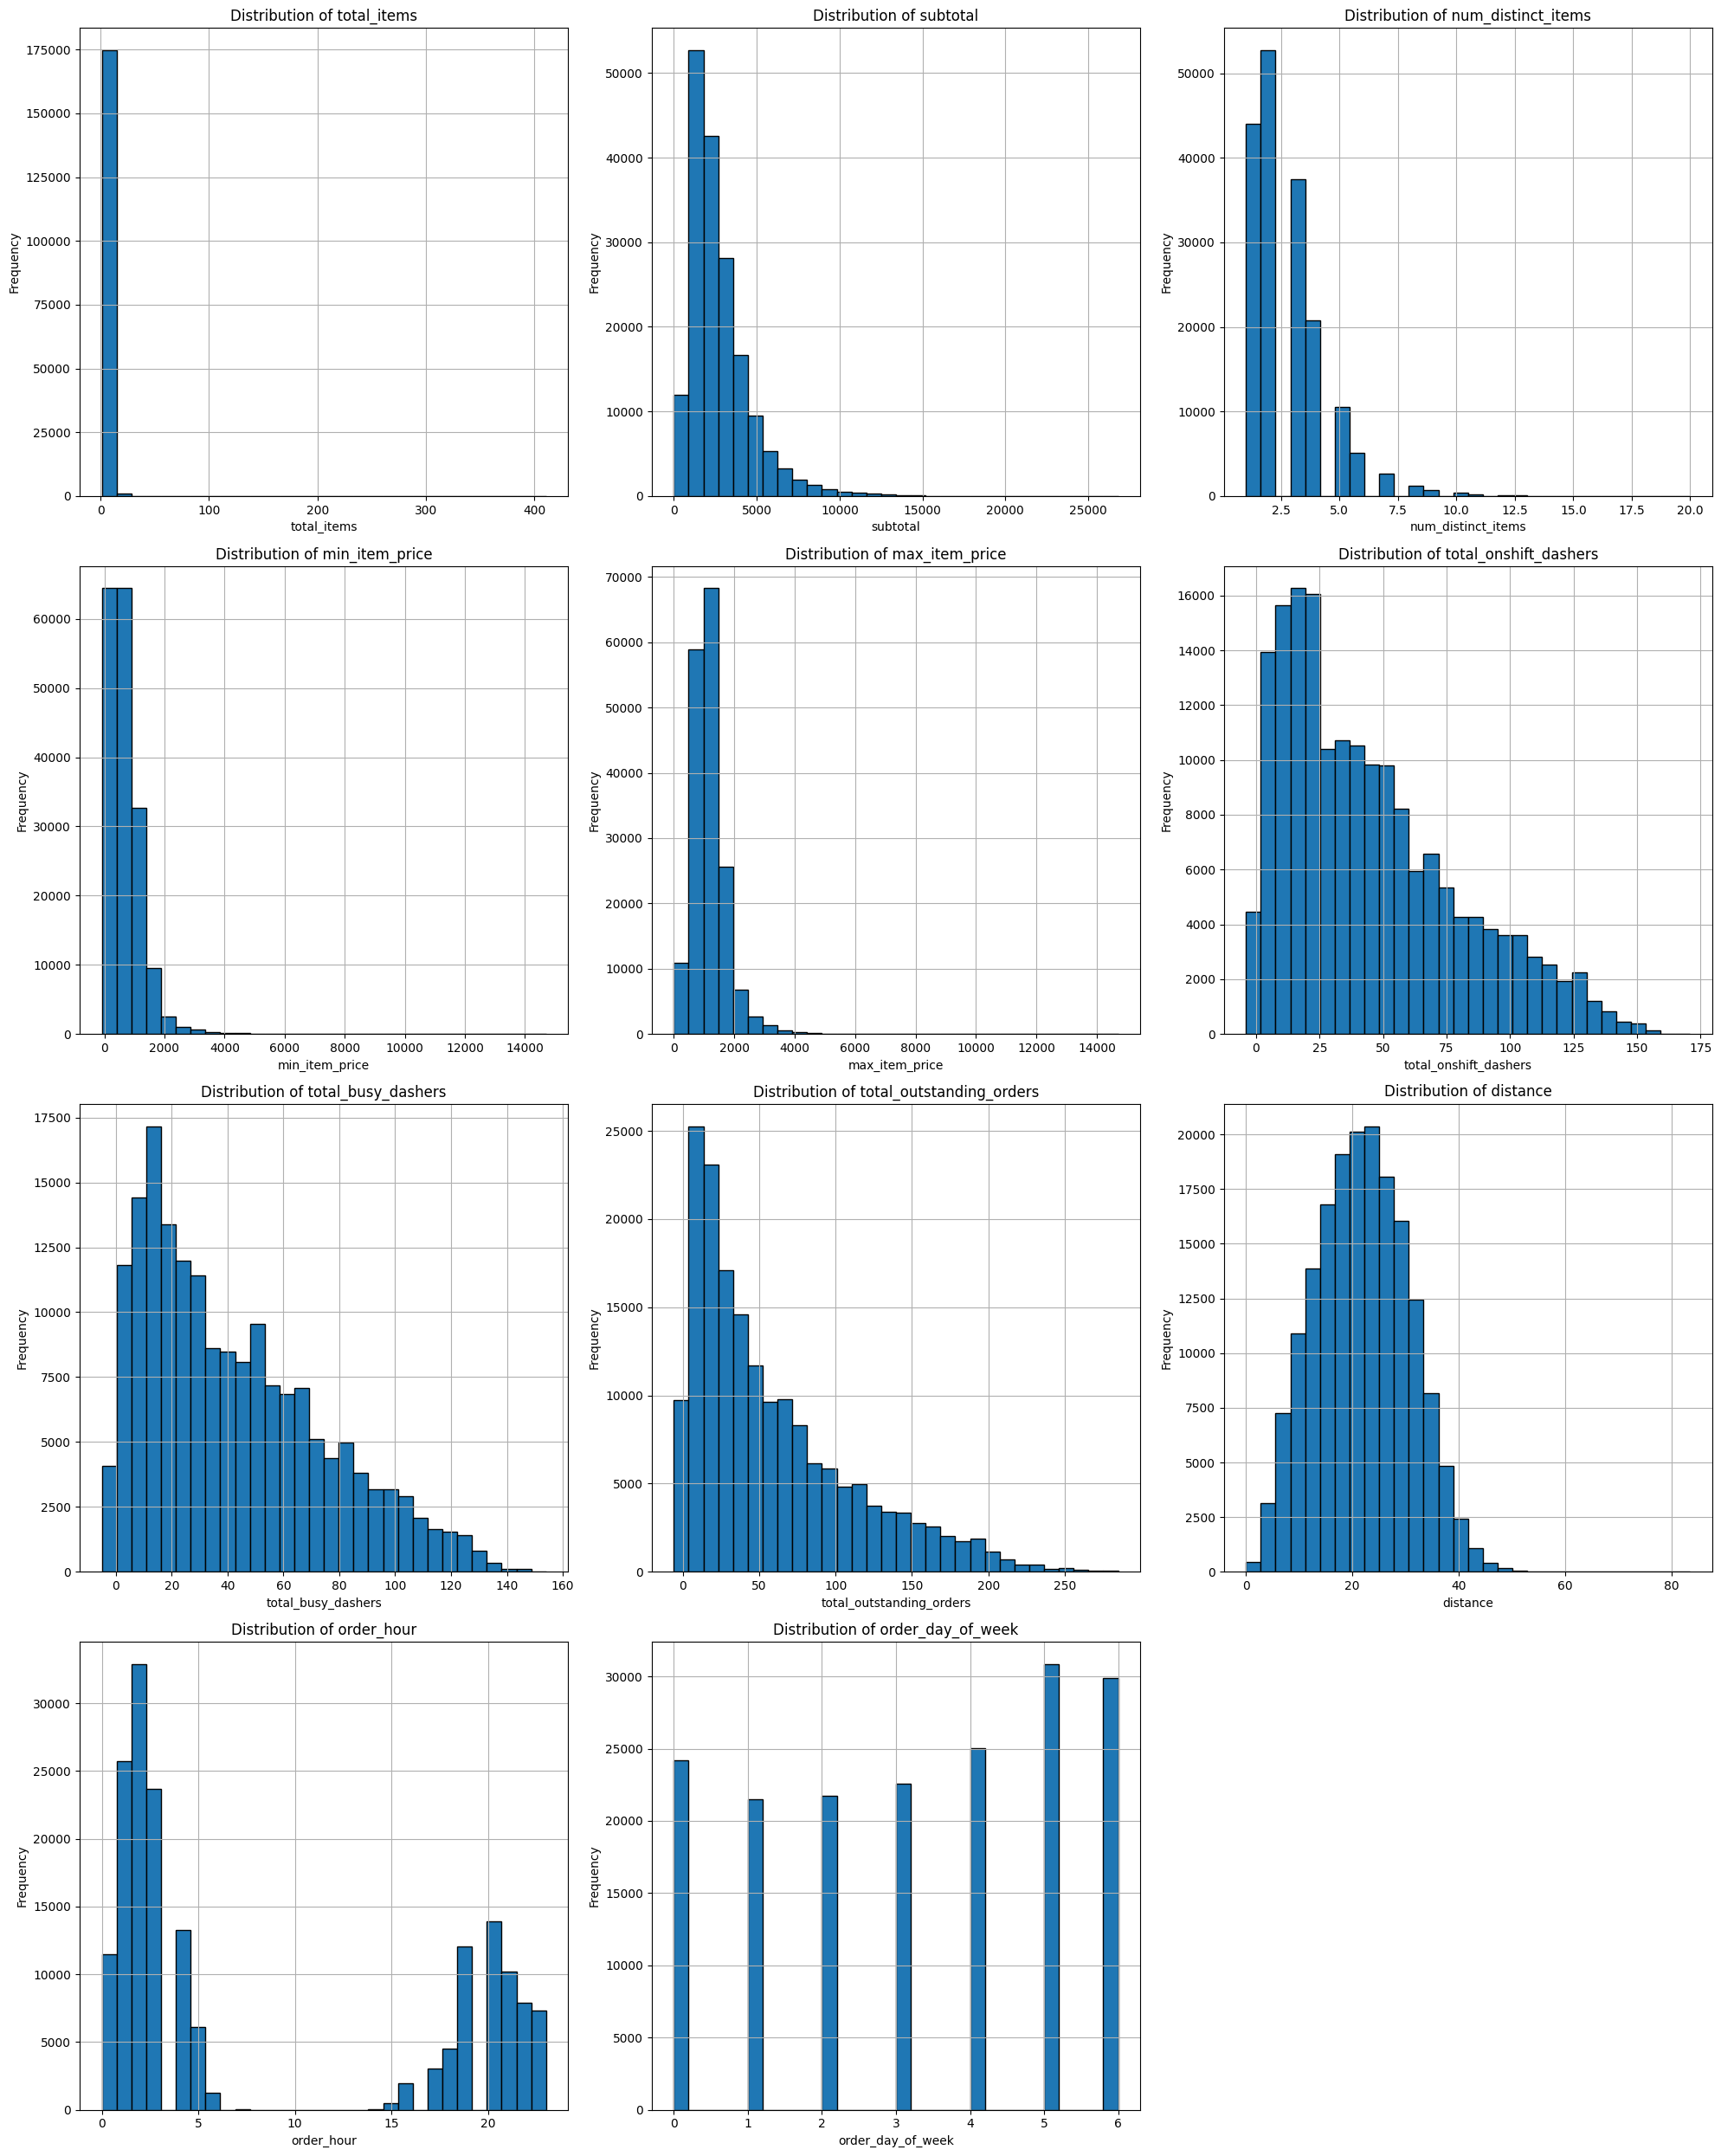

In [13]:
# Plot distributions for all numerical columns

plt.figure(figsize=(20, 25))

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(4, 3, i)
    porter_df_cleaned[column].hist(bins=30, edgecolor='k')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

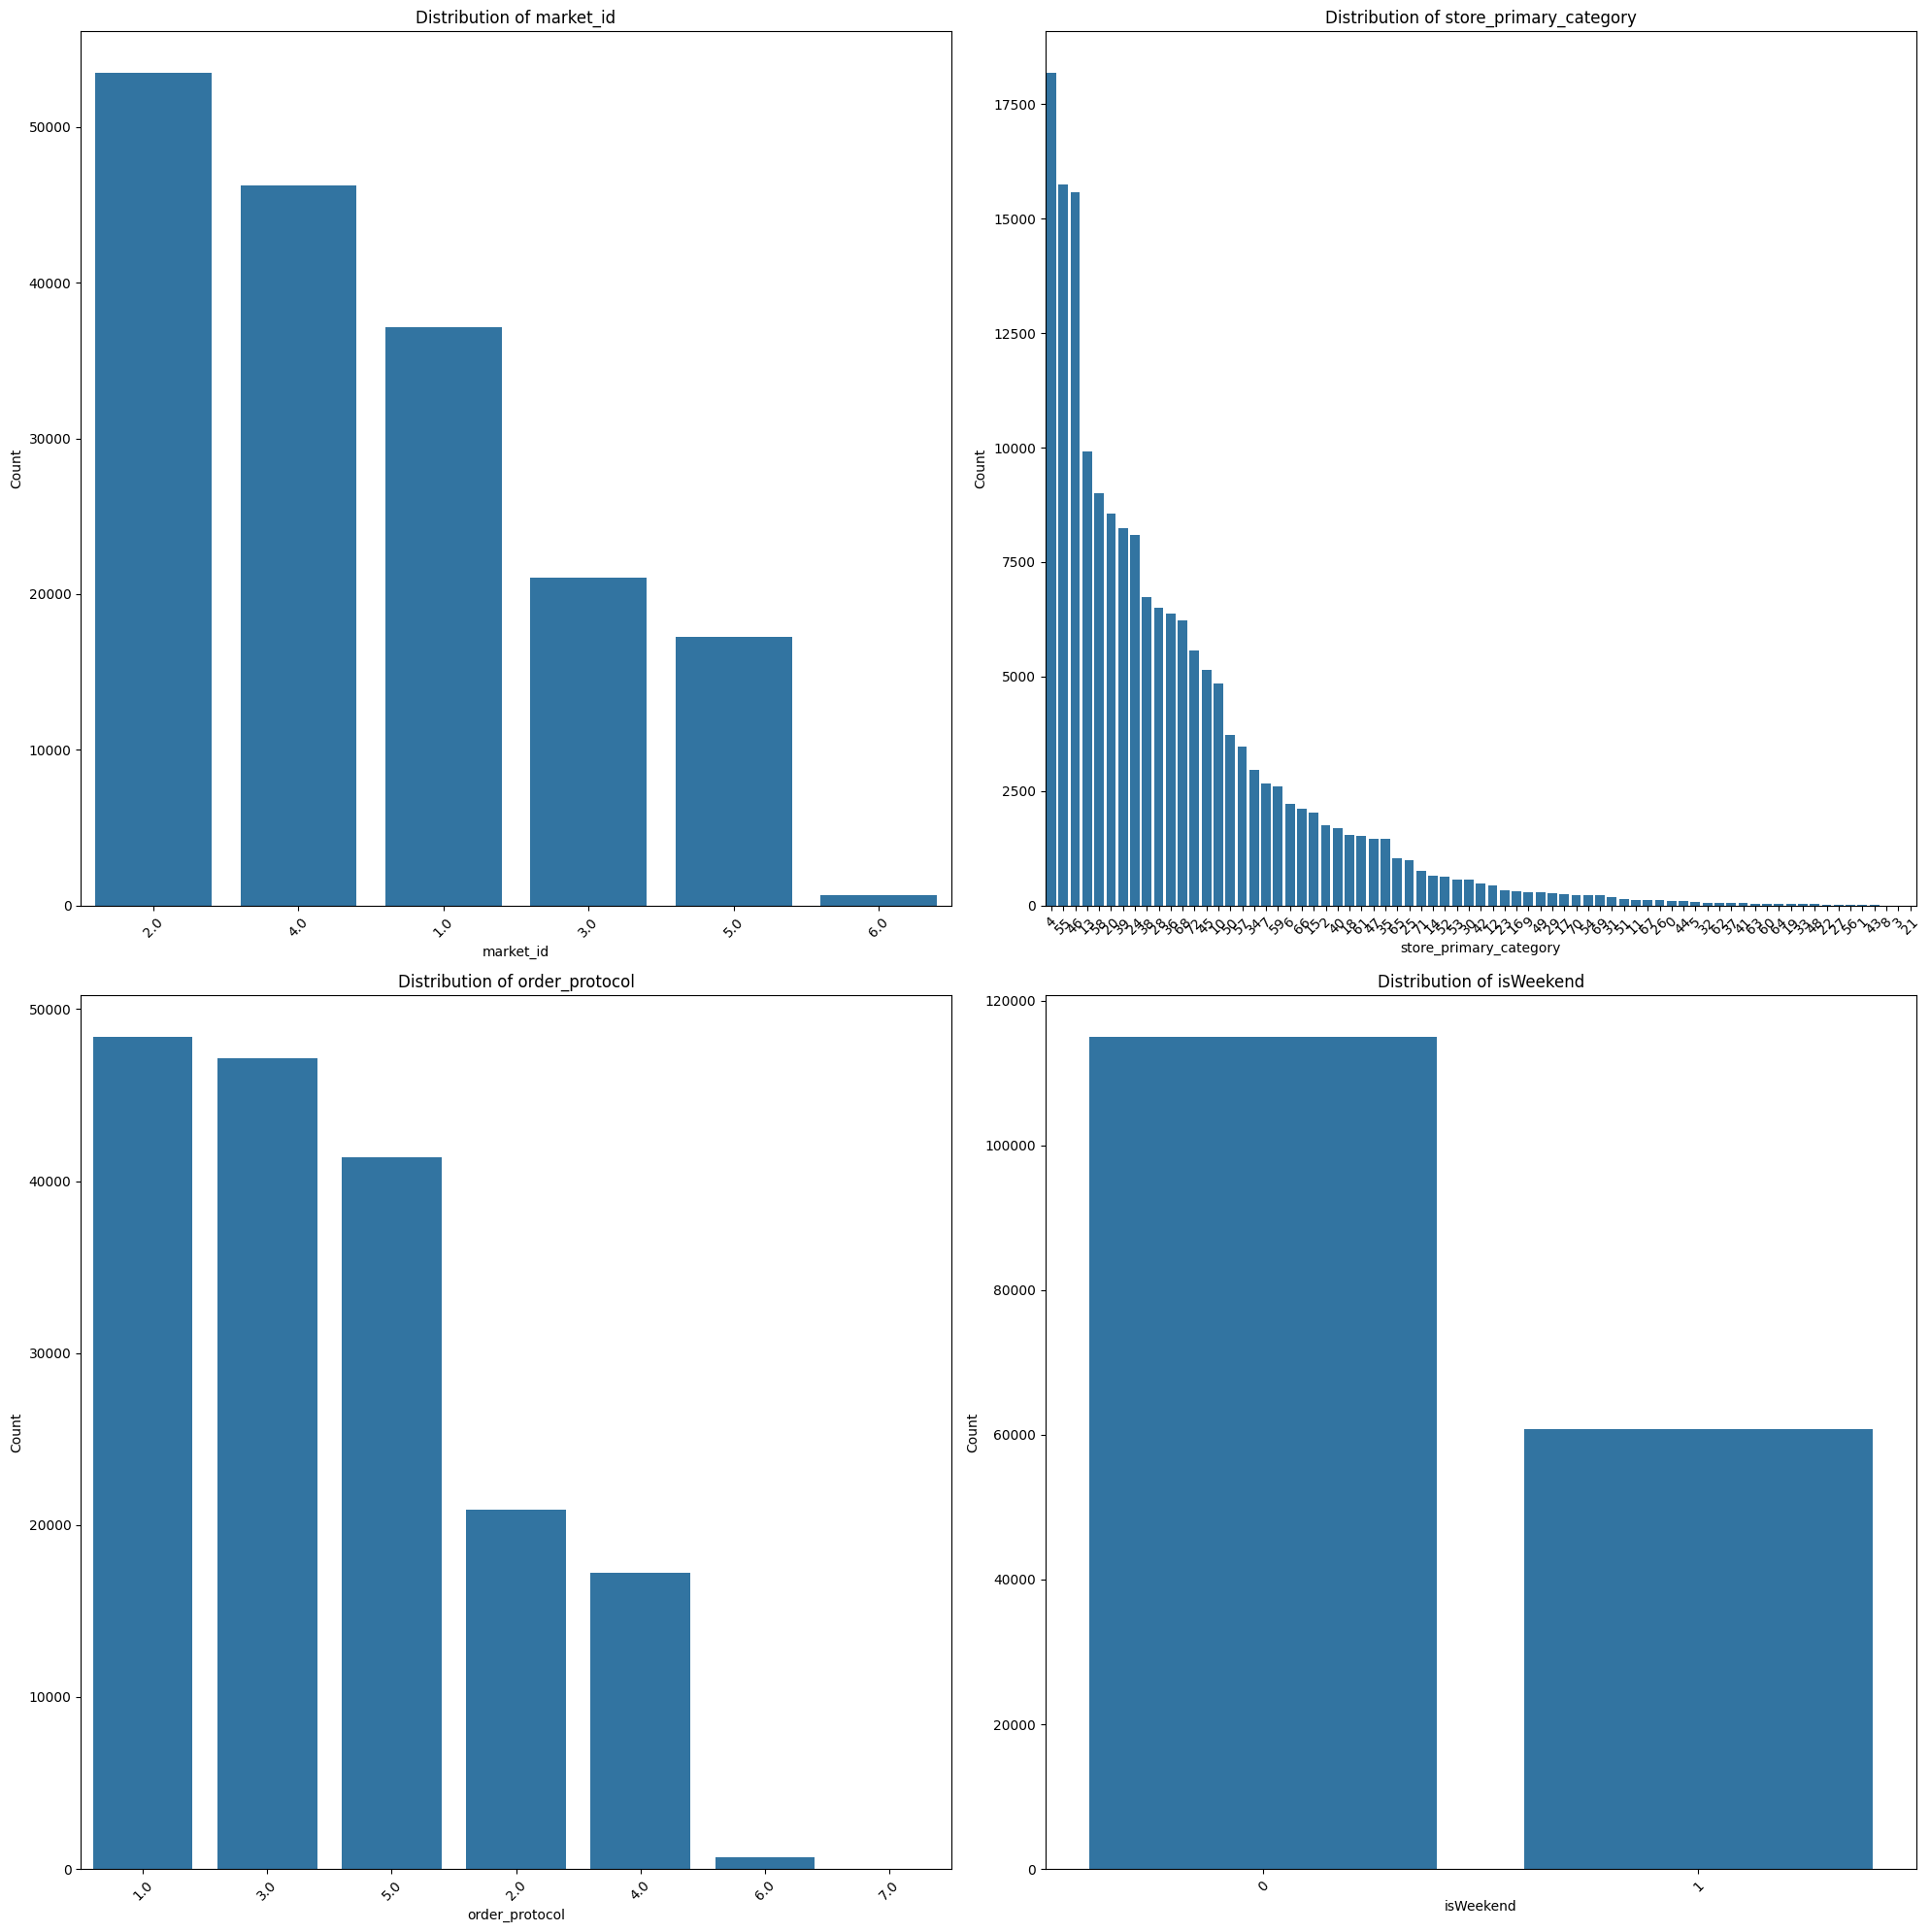

In [15]:
# Distribution of categorical columns

plt.figure(figsize=(20, 20))

for i, column in enumerate(categorical_columns, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=porter_df_cleaned[column], order=porter_df_cleaned[column].value_counts().index)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

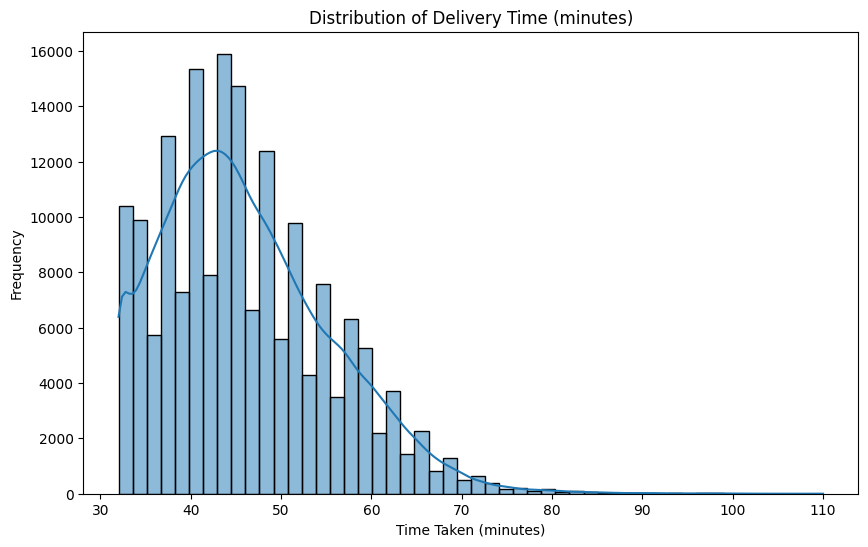

In [16]:
# Distribution of time_taken

plt.figure(figsize=(10, 6))
sns.histplot(porter_df_cleaned['time_taken_minutes'], bins=50, kde=True, edgecolor='k')
plt.title('Distribution of Delivery Time (minutes)')
plt.xlabel('Time Taken (minutes)')
plt.ylabel('Frequency')
plt.show()

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

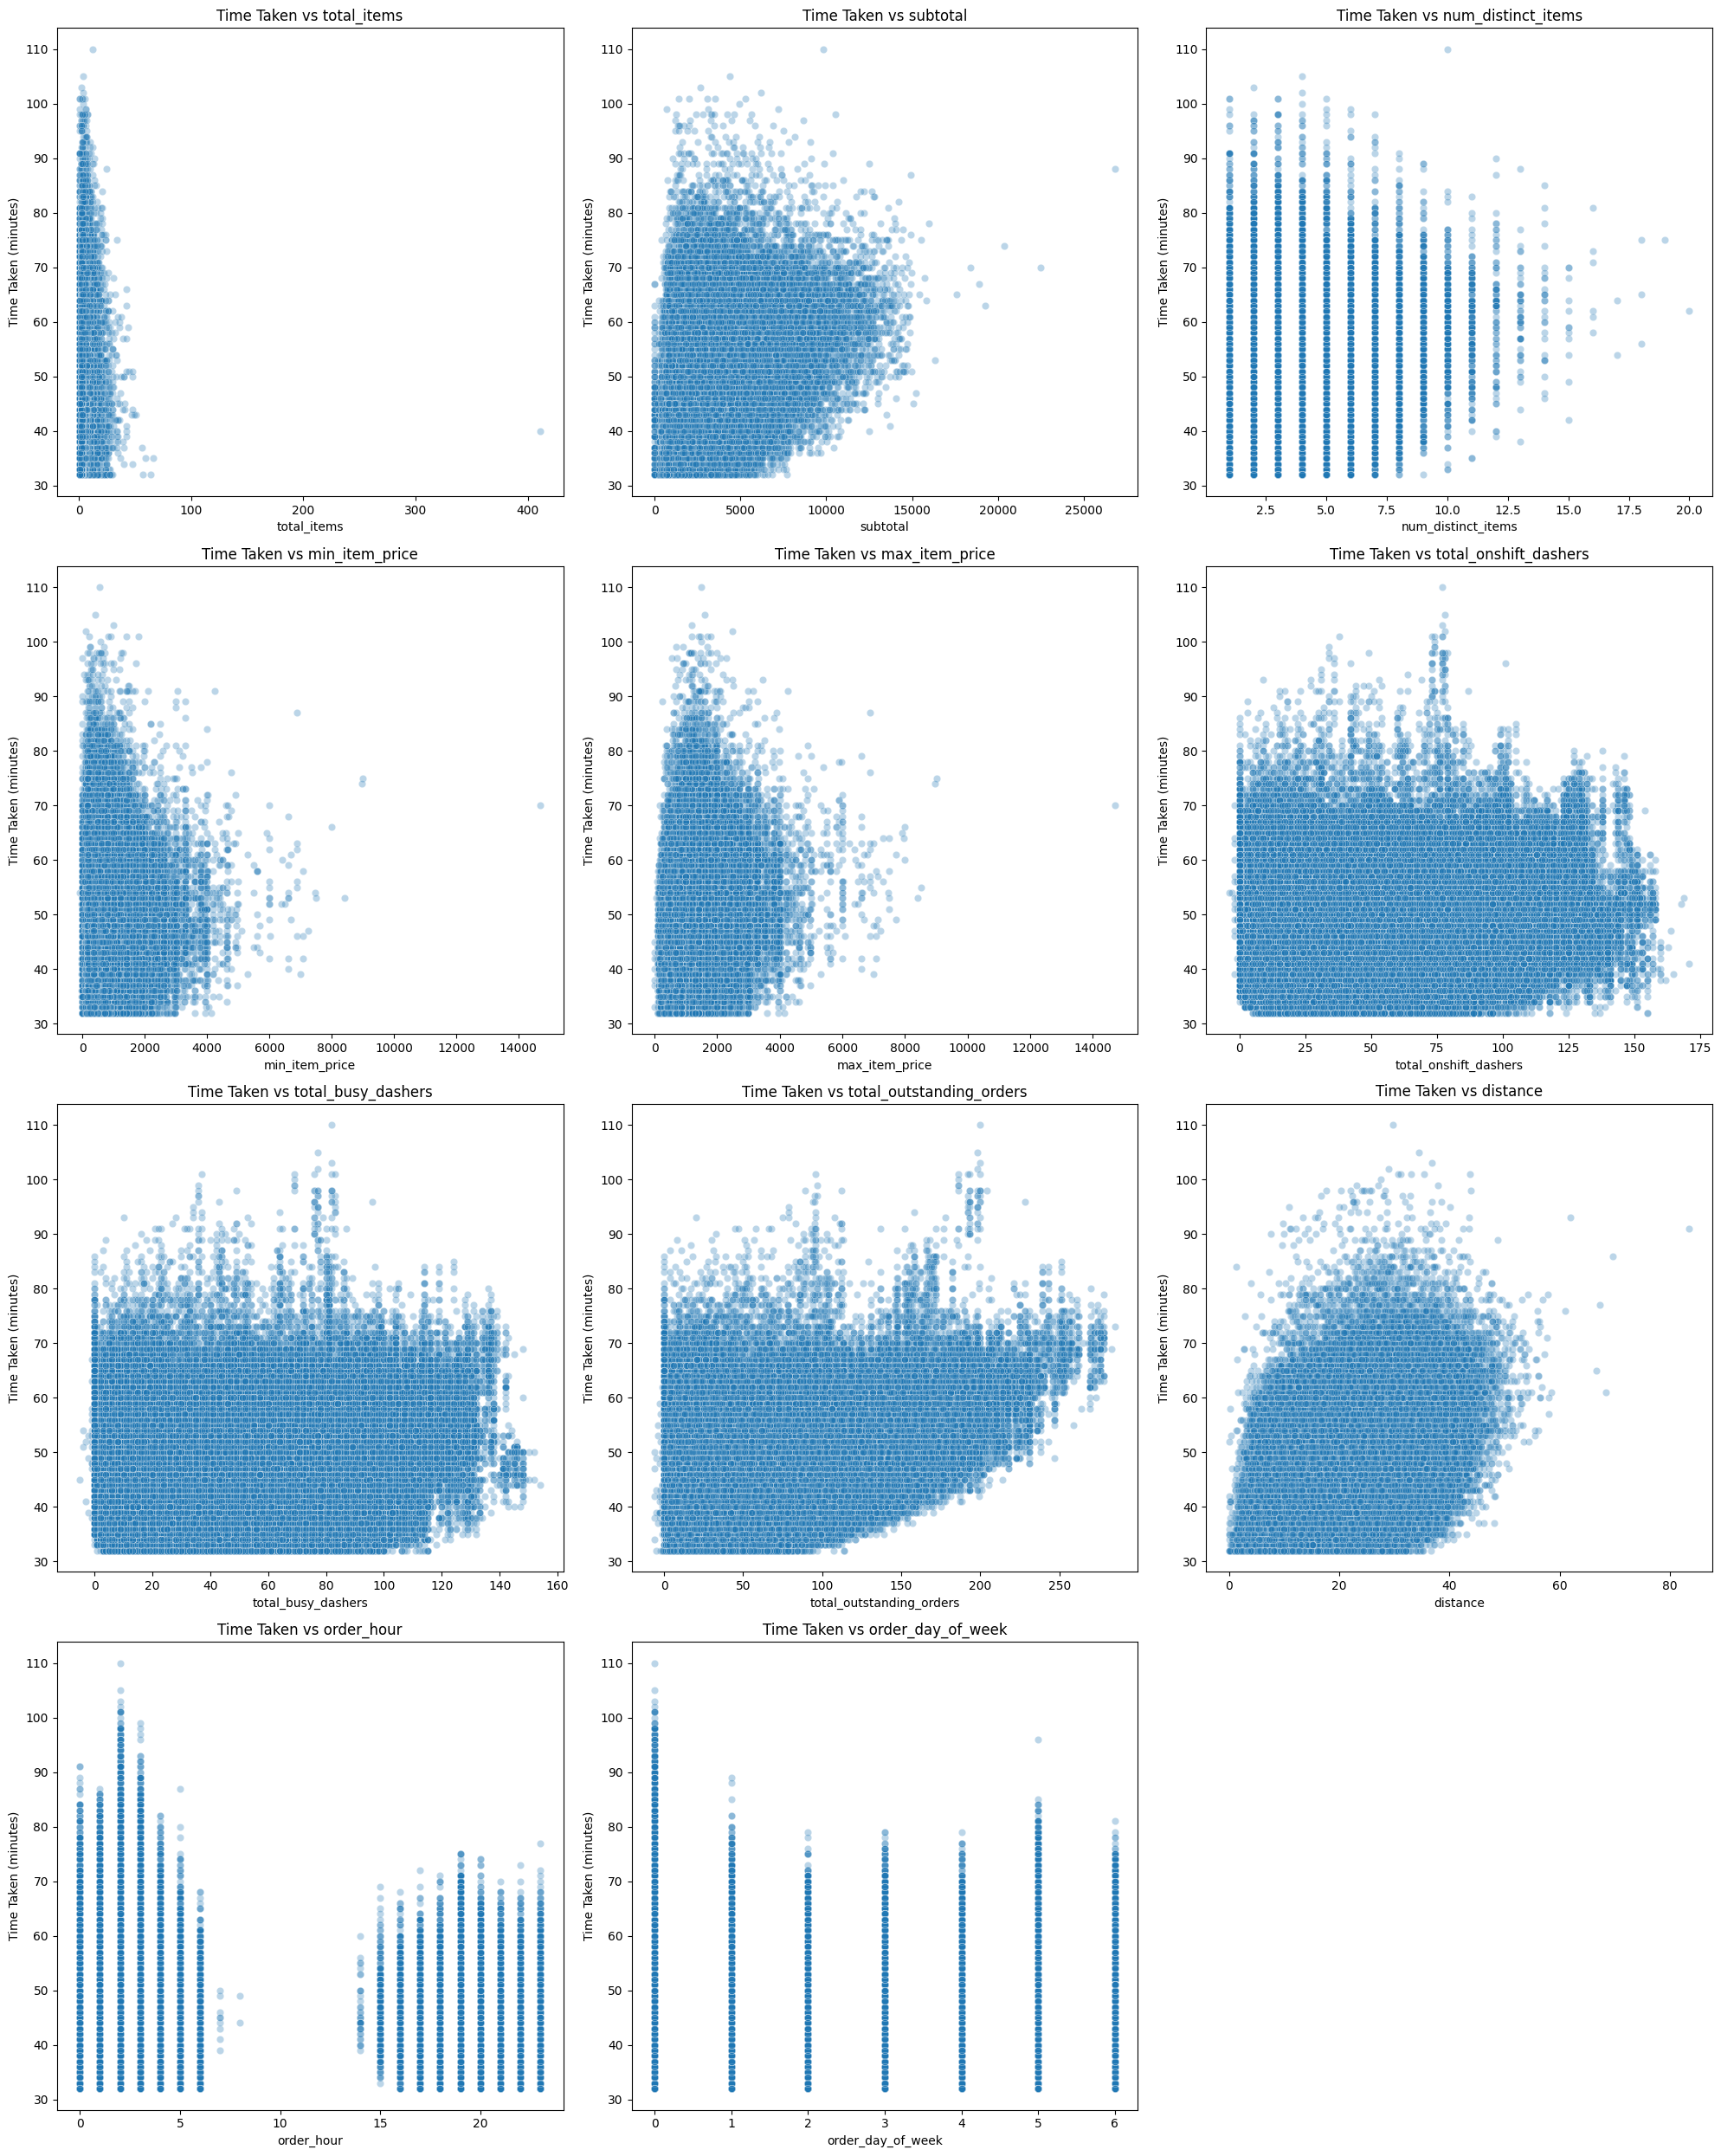

In [17]:
# Scatter plot to visualise the relationship between time_taken and other features

plt.figure(figsize=(20, 25))

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(4, 3, i)
    sns.scatterplot(x=porter_df_cleaned[column], y=porter_df_cleaned['time_taken_minutes'], alpha=0.3)
    plt.title(f'Time Taken vs {column}')
    plt.xlabel(column)
    plt.ylabel('Time Taken (minutes)')

plt.tight_layout()
plt.show()

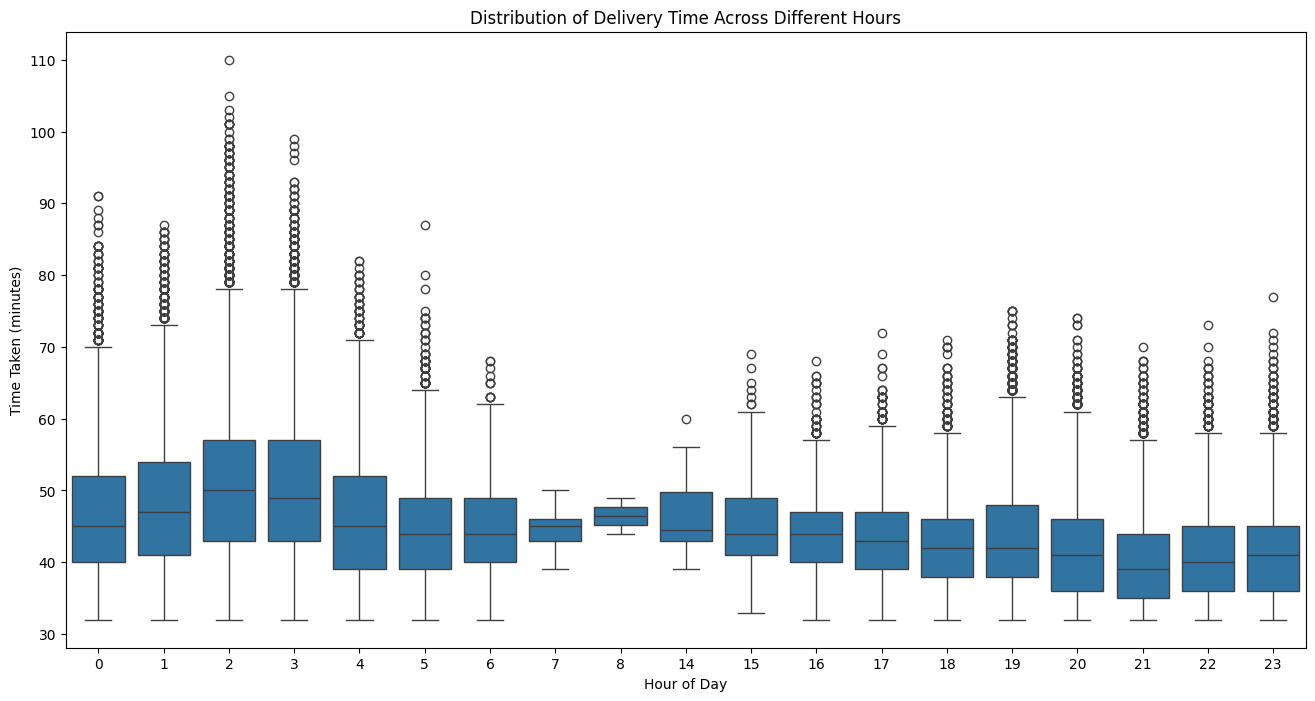

In [18]:
# Show the distribution of time_taken for different hours

plt.figure(figsize=(16, 8))
sns.boxplot(x='order_hour', y='time_taken_minutes', data=porter_df_cleaned)
plt.title('Distribution of Delivery Time Across Different Hours')
plt.xlabel('Hour of Day')
plt.ylabel('Time Taken (minutes)')
plt.show()

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

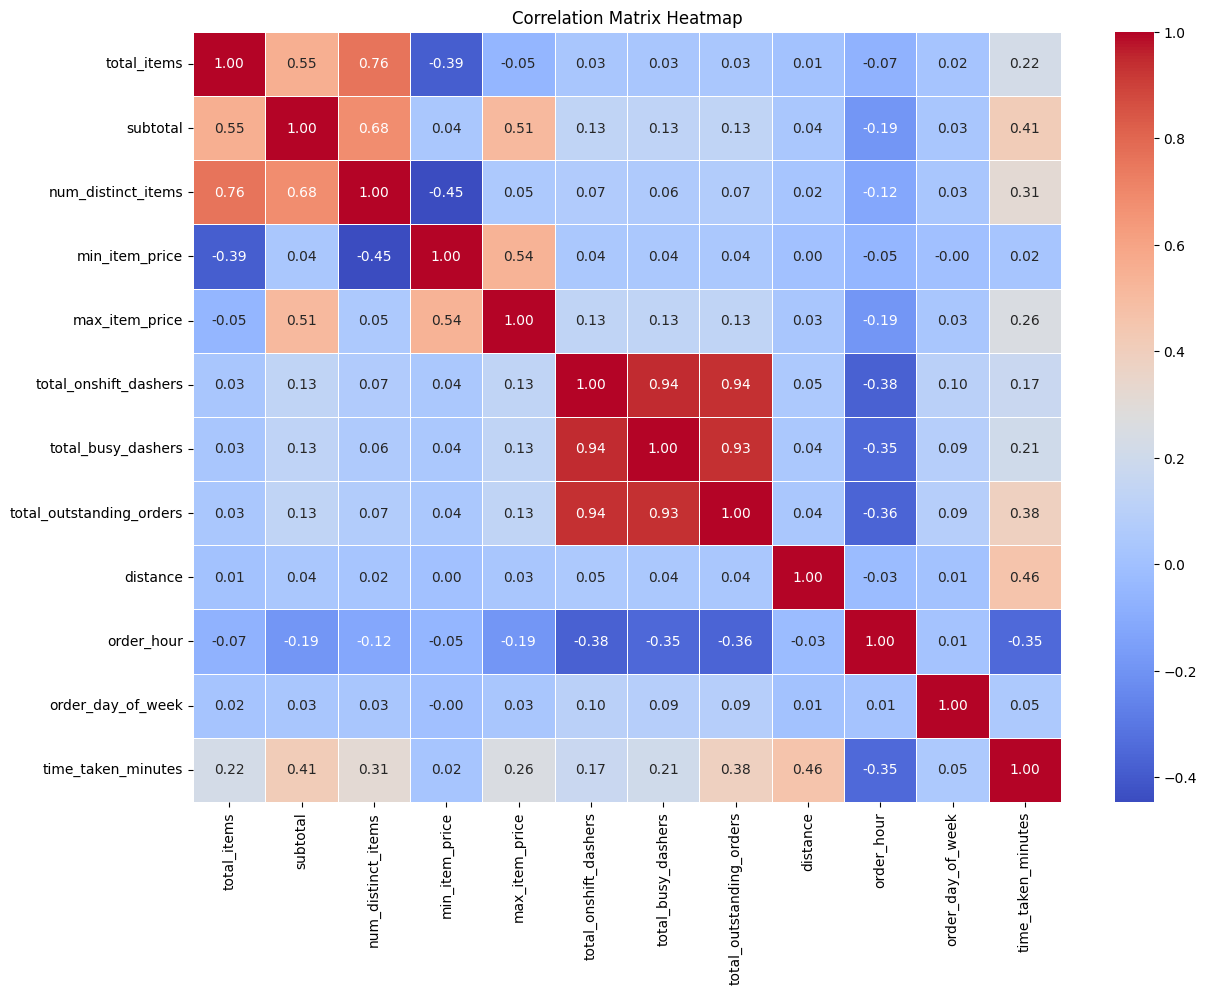

In [19]:
# Plot the heatmap of the correlation matrix

corr_matrix = porter_df_cleaned[numerical_columns + ['time_taken_minutes']].corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [20]:
# Drop 3-5 weakly correlated columns from training dataset

weak_corr_columns = corr_matrix['time_taken_minutes'].abs().sort_values().index[:5].tolist()

# Drop weakly correlated columns from training and testing datasets
X_train_reduced = X_train.drop(columns=weak_corr_columns)
X_test_reduced = X_test.drop(columns=weak_corr_columns)

# Display dropped columns and shape of datasets after dropping
weak_corr_columns, X_train_reduced.shape, X_test_reduced.shape

(['min_item_price',
  'order_day_of_week',
  'total_onshift_dashers',
  'total_busy_dashers',
  'total_items'],
 (123043, 10),
 (52734, 10))

#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

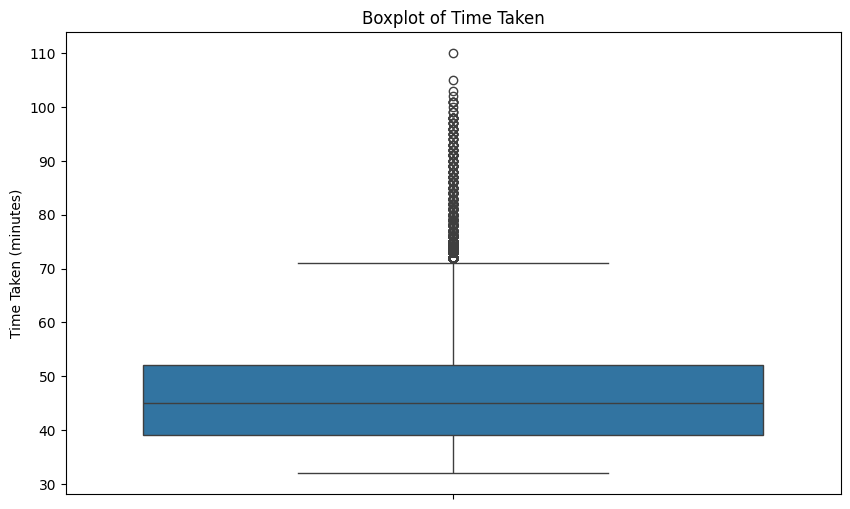

In [29]:
# Boxplot for time_taken

plt.figure(figsize=(10, 6))
sns.boxplot(y=porter_df_cleaned['time_taken_minutes'])
plt.title('Boxplot of Time Taken')
plt.ylabel('Time Taken (minutes)')
plt.show()

##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

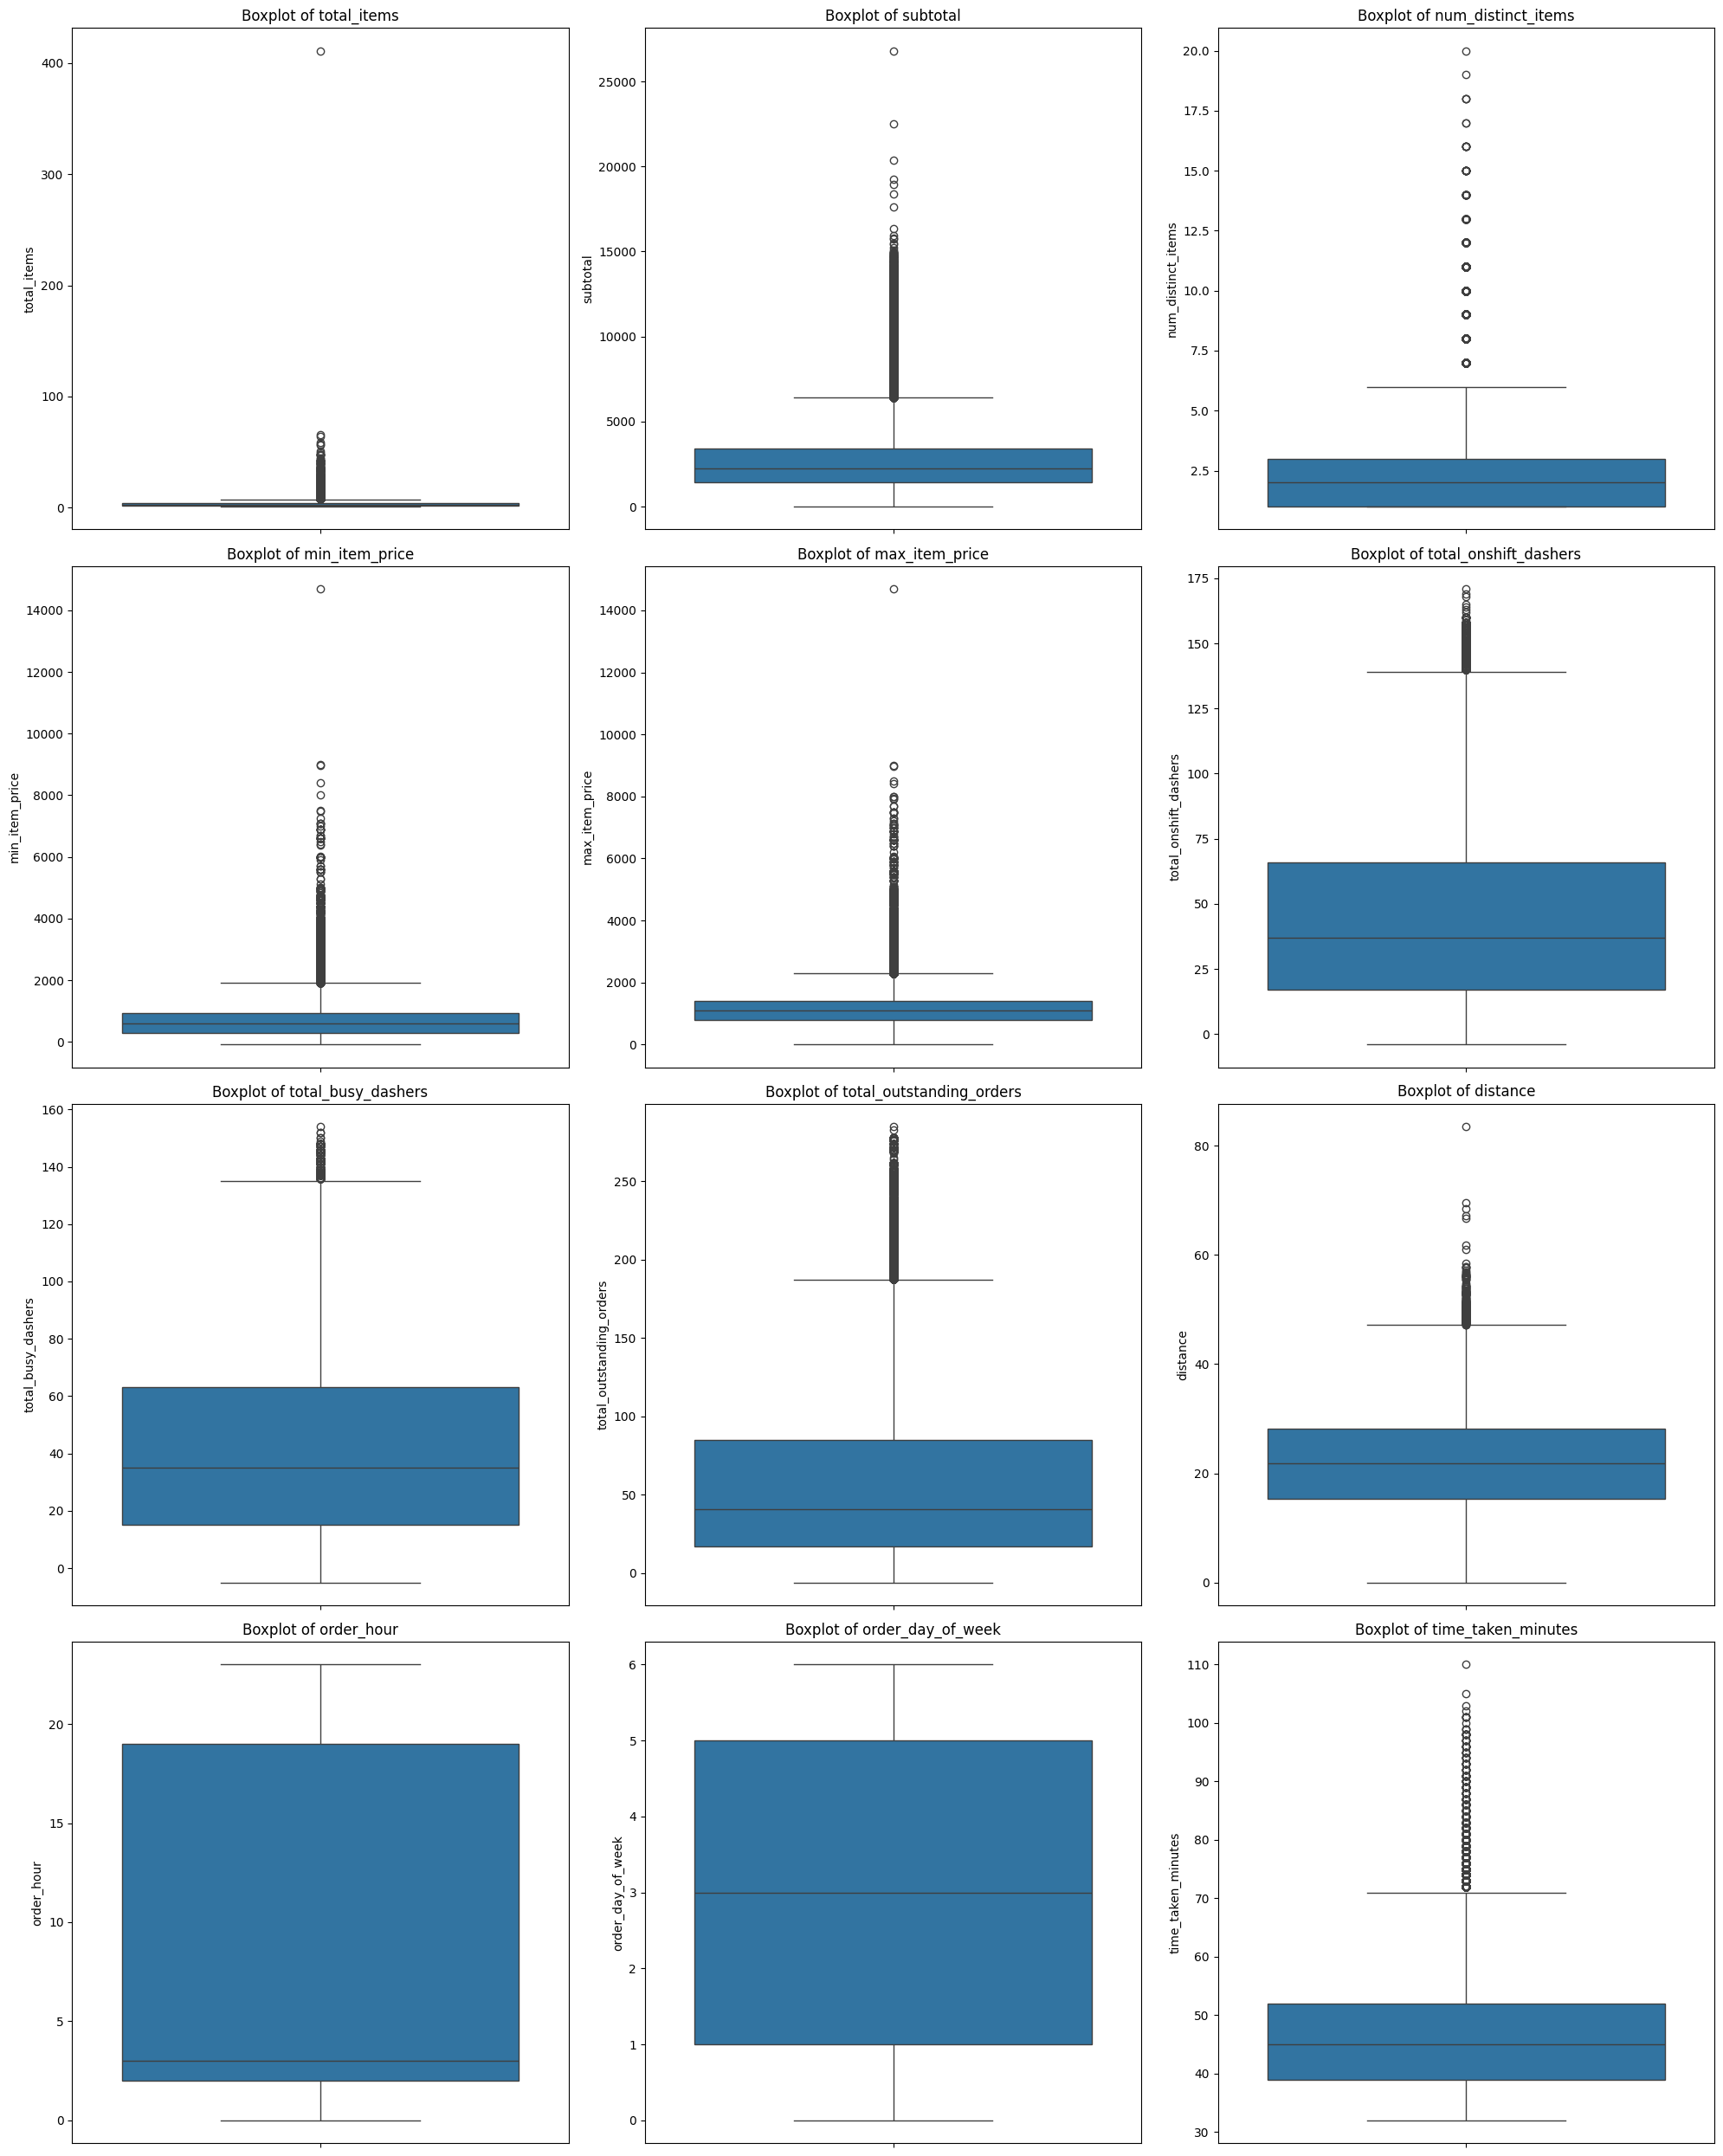

In [30]:
# Handle outliers

plt.figure(figsize=(20, 25))

for i, column in enumerate(numerical_columns + ['time_taken_minutes'], 1):
    plt.subplot(4, 3, i)
    sns.boxplot(y=porter_df_cleaned[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

In [31]:
winsorize_columns = ['time_taken_minutes', 'distance', 'subtotal', 'max_item_price']
for col in winsorize_columns:
    porter_df_cleaned[col] = winsorize(porter_df_cleaned[col], limits=[0.01, 0.01])

# Verify winsorization effect
porter_df_cleaned[winsorize_columns].describe()

time_taken_minutes       distance       subtotal  max_item_price
count       175777.000000  175777.000000  175777.000000   175777.000000
mean            46.138471      21.823621    2681.103557     1152.310621
std              9.111888       8.641476    1745.921214      514.416842
min             32.000000       4.440000     537.000000      259.000000
25%             39.000000      15.360000    1412.000000      799.000000
50%             45.000000      21.760000    2224.000000     1095.000000
75%             52.000000      28.120000    3410.000000     1395.000000
max             71.000000      41.840000    9460.000000     3100.000000

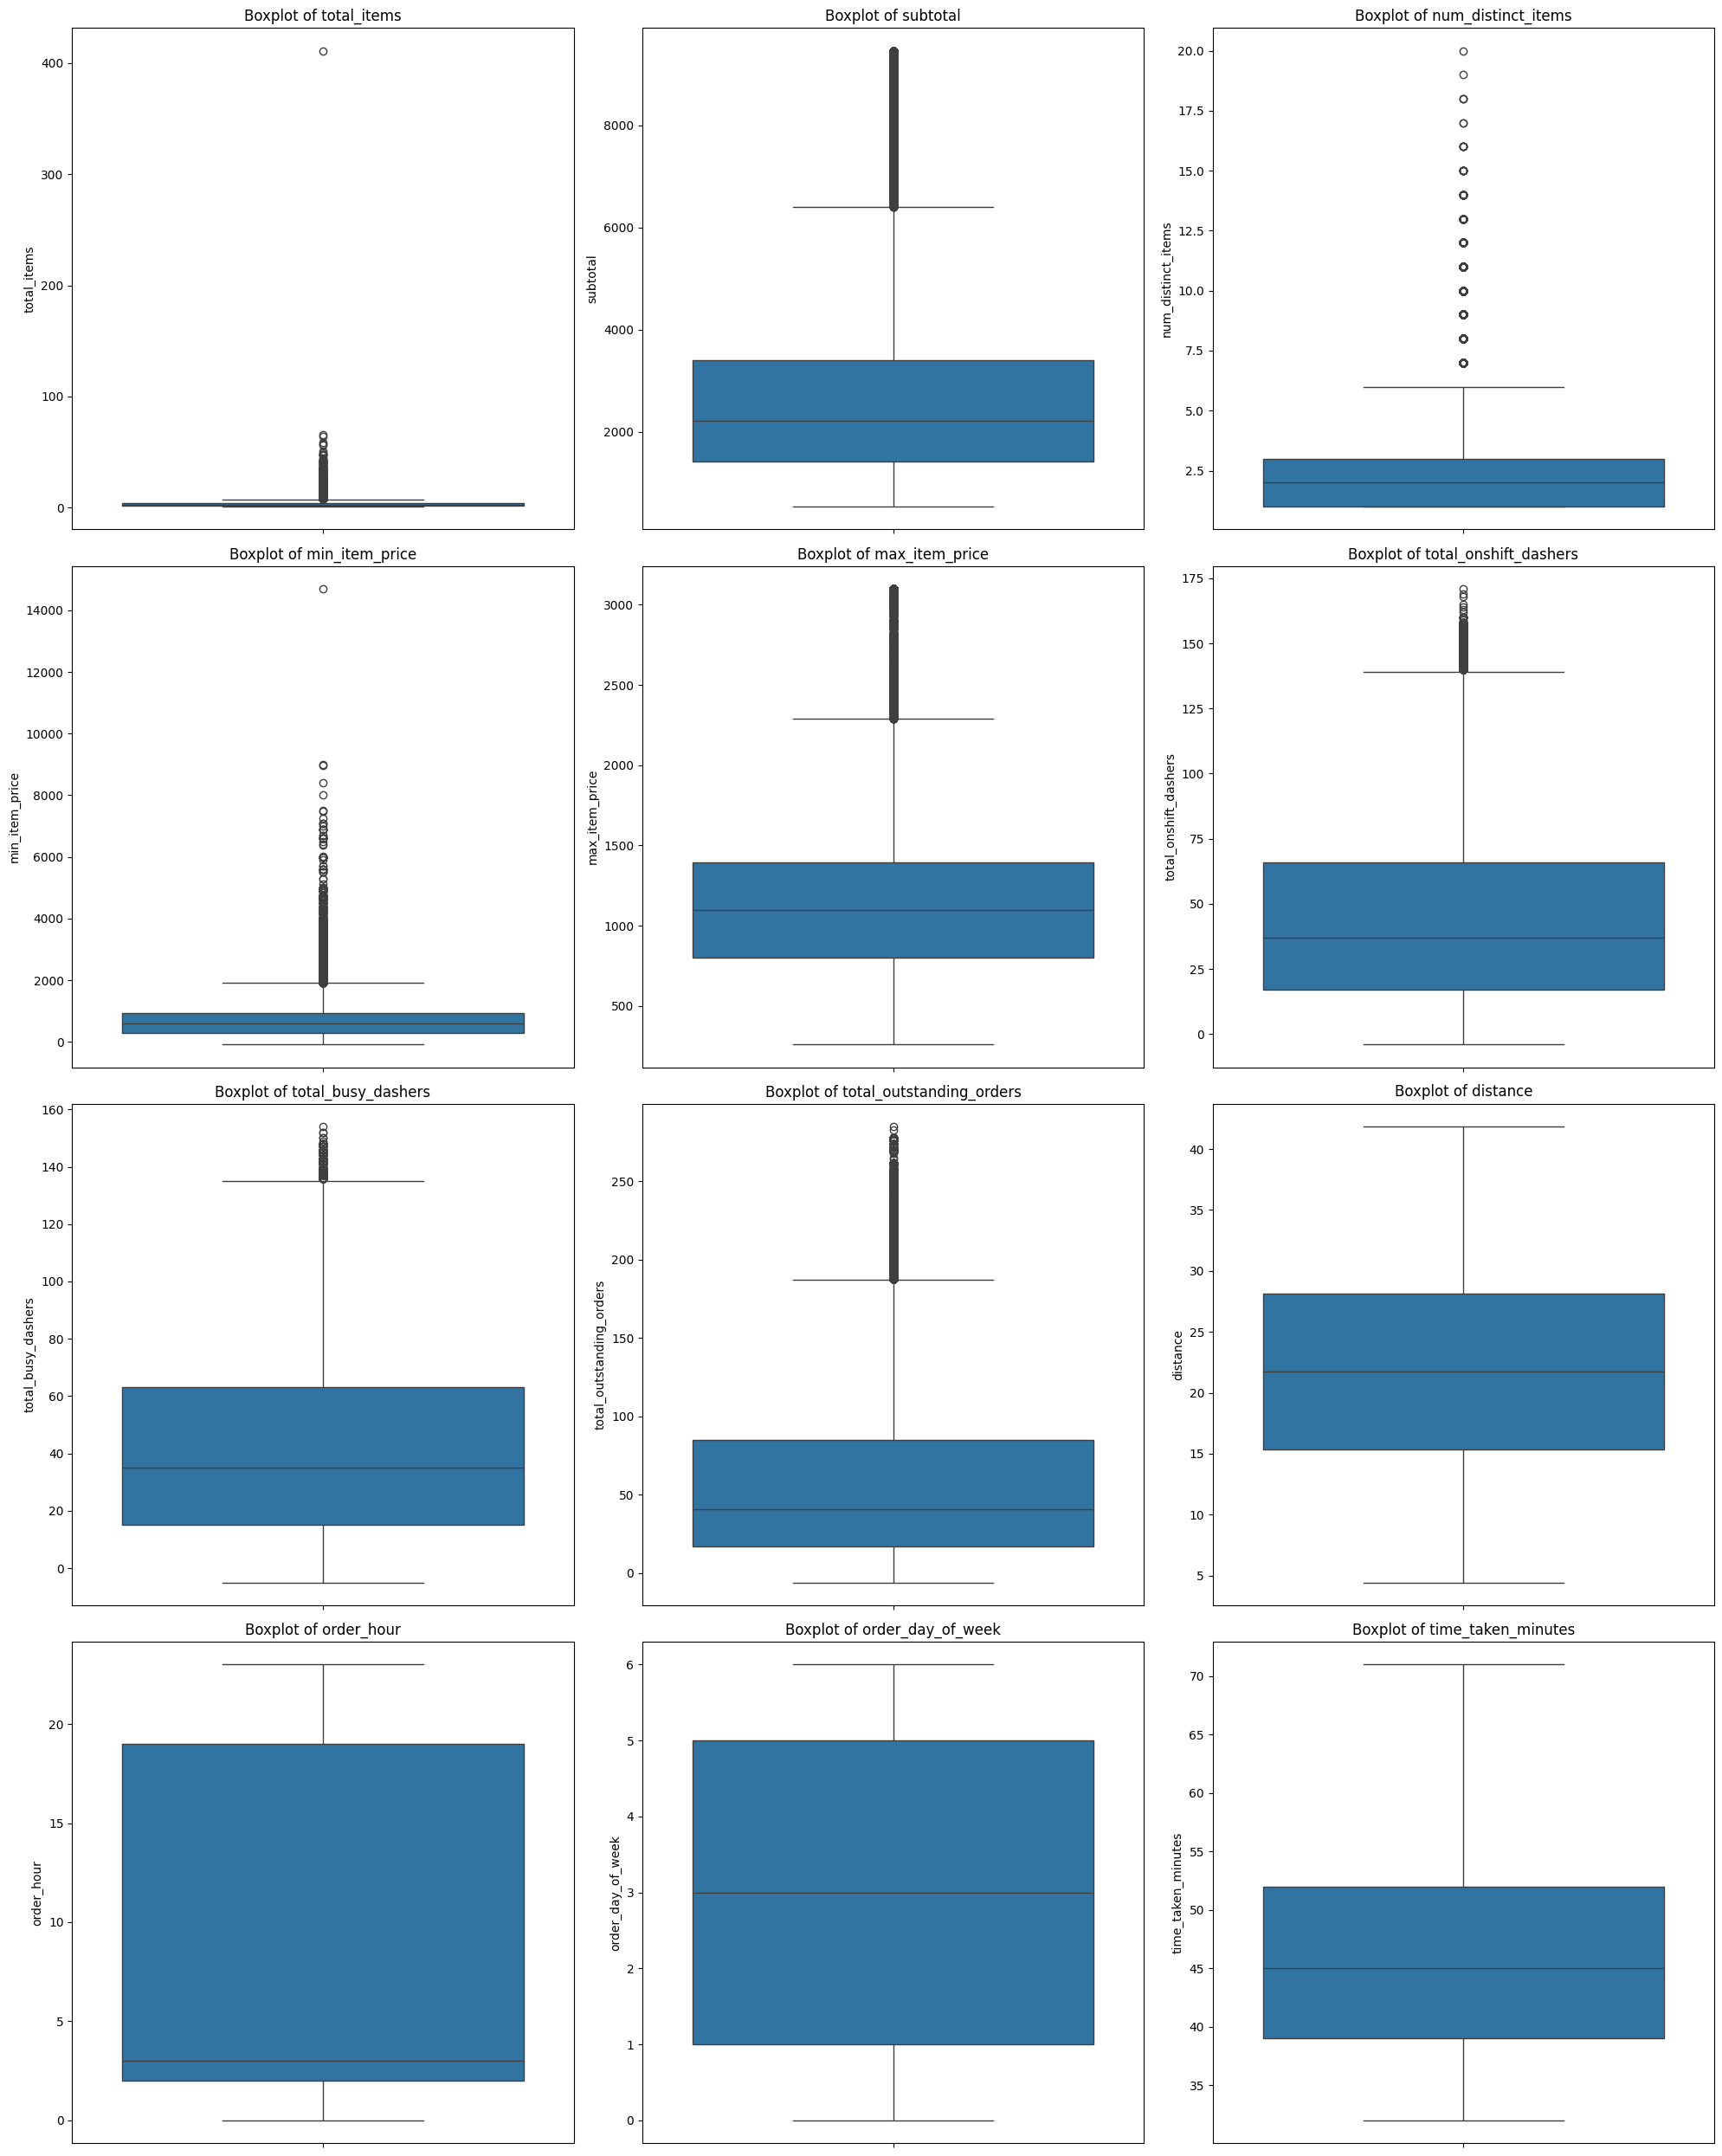

In [32]:
plt.figure(figsize=(20, 25))

for i, column in enumerate(numerical_columns + ['time_taken_minutes'], 1):
    plt.subplot(4, 3, i)
    sns.boxplot(y=porter_df_cleaned[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [33]:
# Define numerical and categorical columns for easy EDA and data manipulation

numerical_columns_test = [
    'subtotal', 'num_distinct_items', 'max_item_price', 'total_outstanding_orders',
    'distance', 'order_hour'
]

categorical_columns_test = [
    'market_id', 'store_primary_category', 'order_protocol', 'isWeekend'
]

# Verify numerical and categorical distributions in test data
(X_test_reduced[numerical_columns_test].describe(),
 X_test_reduced[categorical_columns_test].describe(include='category'))

(           subtotal  num_distinct_items  max_item_price  \
 count  52734.000000        52734.000000    52734.000000   
 mean    2696.903857            2.672166     1162.006656   
 std     1818.607827            1.620784      562.877886   
 min        0.000000            1.000000        0.000000   
 25%     1420.000000            2.000000      799.000000   
 50%     2235.000000            2.000000     1095.000000   
 75%     3405.750000            3.000000     1395.000000   
 max    20350.000000           18.000000    14700.000000   
 
        total_outstanding_orders      distance    order_hour  
 count              52734.000000  52734.000000  52734.000000  
 mean                  58.202393     21.849092      8.444571  
 std                   52.647355      8.765710      8.675471  
 min                   -4.000000      0.000000      0.000000  
 25%                   17.000000     15.320000      2.000000  
 50%                   41.000000     21.760000      3.000000  
 75%             

#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

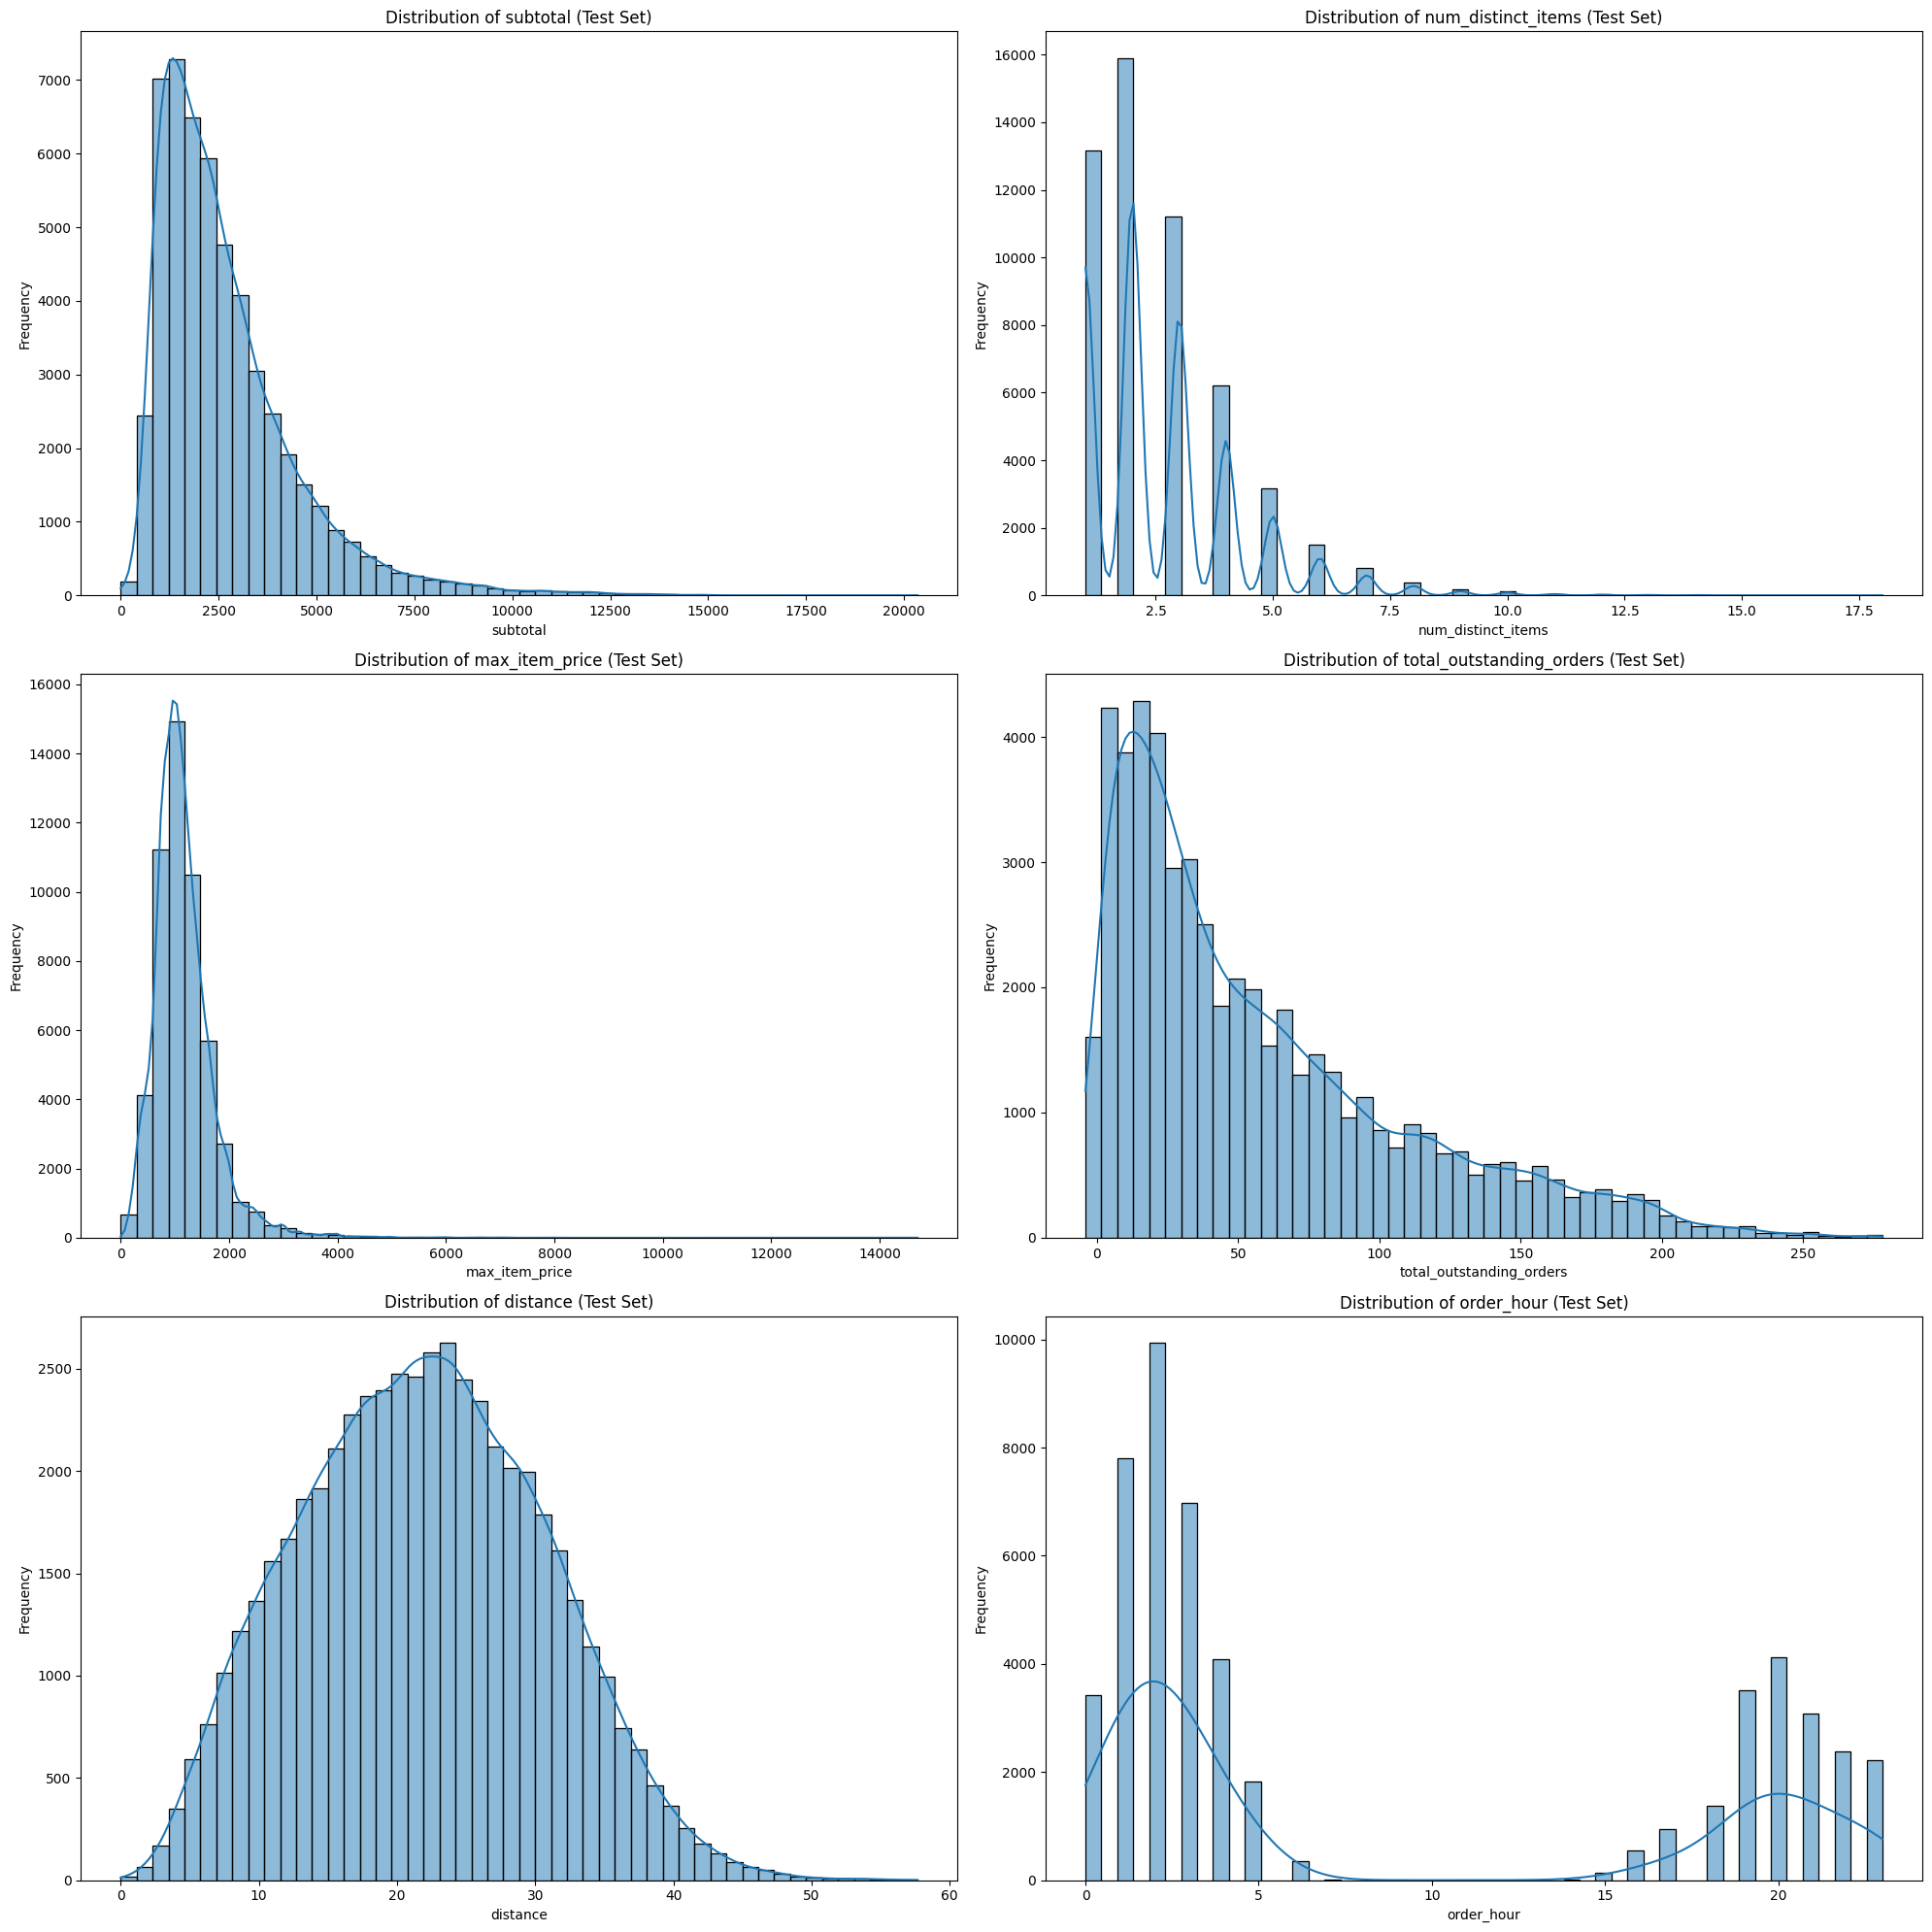

In [34]:
# Plot distributions for all numerical columns

plt.figure(figsize=(20, 20))

for i, column in enumerate(numerical_columns_test, 1):
    plt.subplot(3, 2, i)
    sns.histplot(X_test_reduced[column], bins=50, kde=True, edgecolor='k')
    plt.title(f'Distribution of {column} (Test Set)')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

##### **4.1.2**
Check the distribution of categorical features

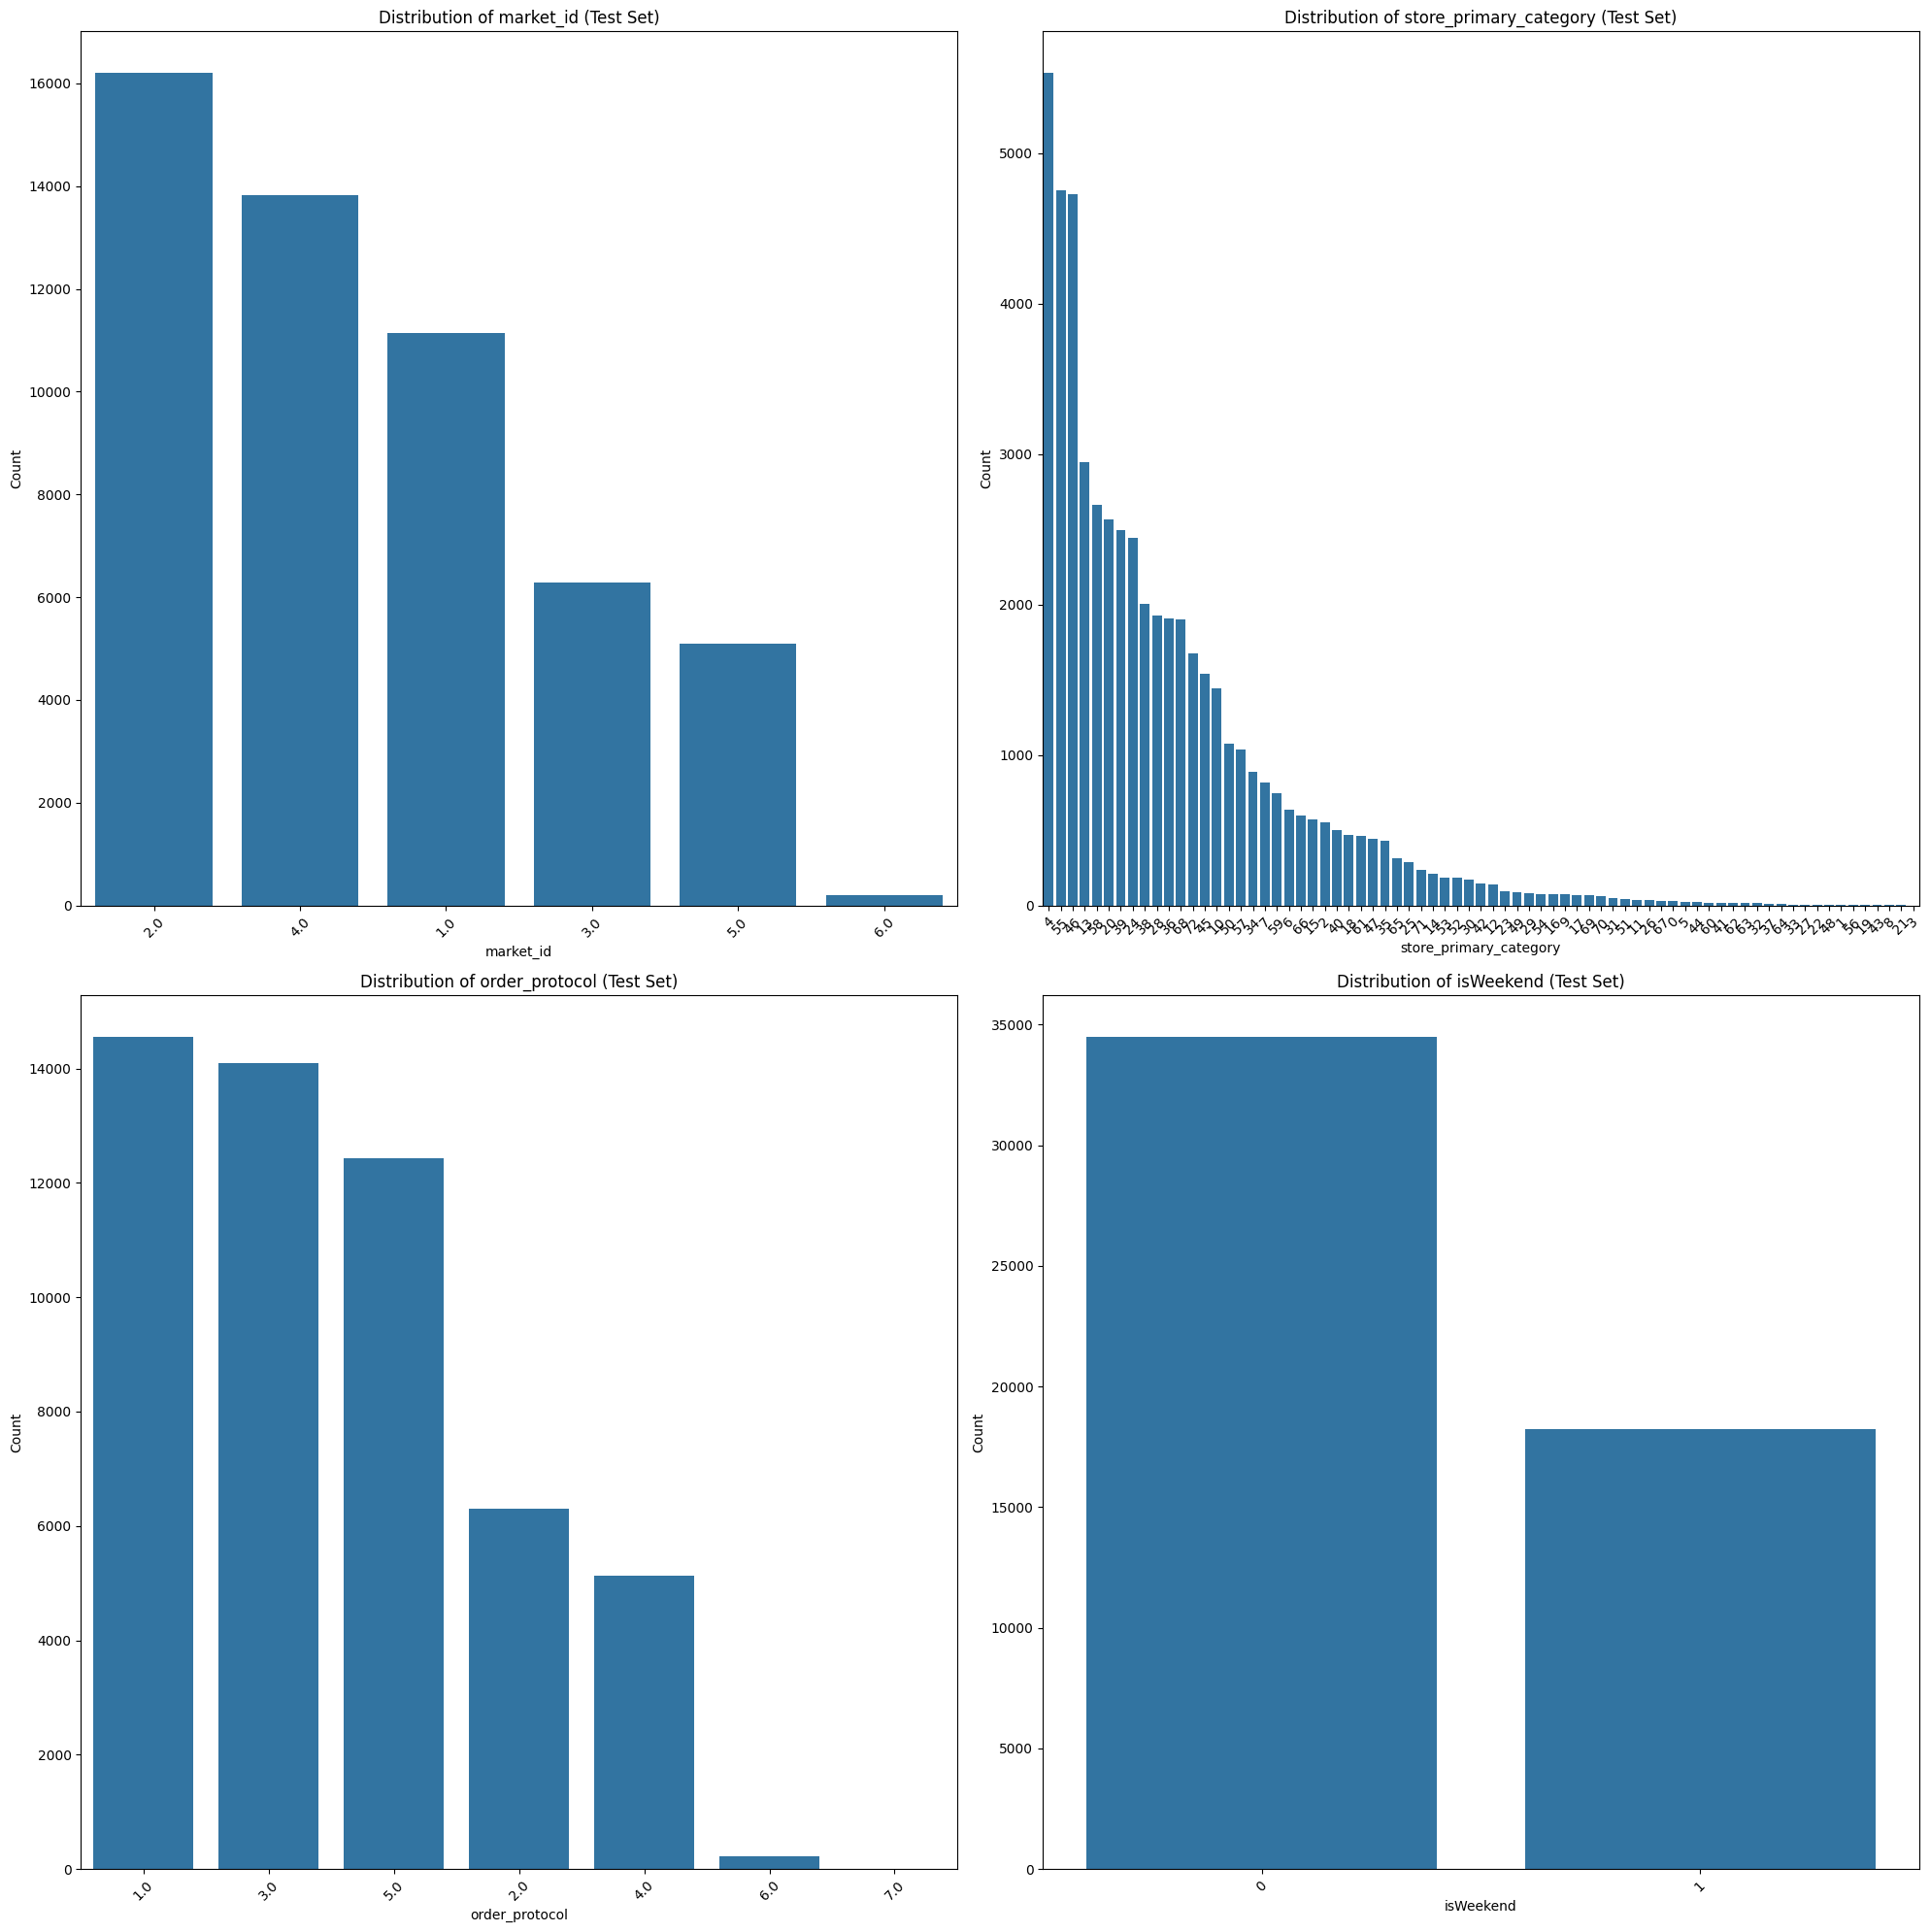

In [35]:
# Distribution of categorical columns

plt.figure(figsize=(20, 20))

for i, column in enumerate(categorical_columns_test, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=X_test_reduced[column], order=X_test_reduced[column].value_counts().index)
    plt.title(f'Distribution of {column} (Test Set)')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

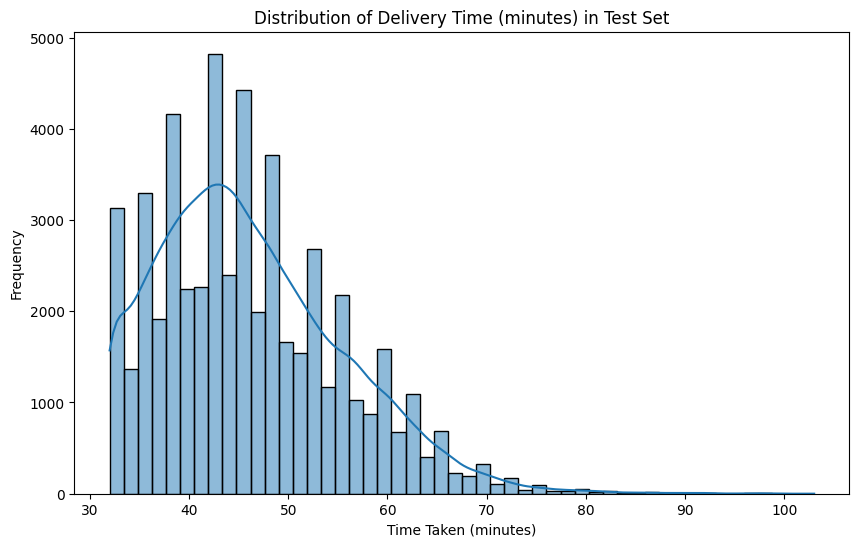

In [36]:
# Distribution of time_taken

plt.figure(figsize=(10, 6))
sns.histplot(y_test, bins=50, kde=True, edgecolor='k')
plt.title('Distribution of Delivery Time (minutes) in Test Set')
plt.xlabel('Time Taken (minutes)')
plt.ylabel('Frequency')
plt.show()

#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

In [39]:
# Scatter plot to visualise the relationship between time_taken and other features


#### **4.3** Drop the columns with weak correlations with the target variable

In [ ]:
# Drop the weakly correlated columns from training dataset



## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [58]:
# Import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.stats as stats

#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [43]:
# Apply scaling to the numerical columns

numerical_columns = [
    'total_items', 'subtotal', 'num_distinct_items', 
    'min_item_price', 'max_item_price', 'total_onshift_dashers', 
    'total_busy_dashers', 'total_outstanding_orders', 'distance'
]

# Initialize the scaler
scaler = StandardScaler()

# Apply scaling to the numerical columns
X_scaled = X.copy()
X_scaled[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# Display the first few rows of the scaled DataFrame
X_scaled.head()

market_id store_primary_category order_protocol  total_items  subtotal  \
0       1.0                      4            1.0     0.297311  0.406819   
1       2.0                     46            2.0    -0.824584 -0.435925   
2       2.0                     36            3.0     0.297311  1.134171   
3       1.0                     38            1.0    -0.824584 -0.641006   
4       1.0                     38            1.0    -0.450619  0.504711   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0            0.815009       -0.246143        0.140581              -0.345022   
1           -1.030377        1.375380        0.427657              -1.271360   
2            0.199880        0.259741        0.791405              -1.068724   
3           -1.030377        1.615819        0.650542              -1.155568   
4           -0.415249        1.423468        1.845206              -1.155568   

   total_busy_dashers  total_outstanding_orders  distance  order_hour  \
0           -0.866110                 -0.706040  1.439863          22   
1           -1.239147                 -1.066360  0.658031          21   
2           -1.114801                 -0.762933 -1.175387           0   
3           -1.114801                 -0.952575  1.138103           3   
4           -1.145887                 -0.971539 -1.559444           2   

   order_day_of_week isWeekend  
0                  4         0  
1                  1         0  
2                  0         0  
3                  3         0  
4                  1         0

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [46]:
# Convert categorical features using one-hot encoding
X_encoded = pd.get_dummies(X_scaled, drop_first=True)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
# Initialize linear regression model
lr = LinearRegression()
# Apply Recursive Feature Elimination (RFE) to select top 8 features
rfe = RFE(estimator=lr, n_features_to_select=8)
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_encoded.columns[rfe.support_]


In [47]:
# Train the model using the training data
lr.fit(X_train[selected_features], y_train)

LinearRegression()

In [48]:
# Make predictions
y_pred = lr.predict(X_test[selected_features])

In [49]:
# Find results for evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

(selected_features.tolist(), mse, mae, r2)


(['subtotal',
  'total_onshift_dashers',
  'total_busy_dashers',
  'total_outstanding_orders',
  'distance',
  'market_id_2.0',
  'market_id_4.0',
  'store_primary_category_3'],
 14.497197868385557,
 2.8784358854627183,
 0.8343693852571756)

Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [51]:
# Loop through the number of features and test the model
reduced_X = X_scaled.copy()

# Keep only key categorical columns to encode
categorical_to_encode = ['order_protocol']
reduced_X = pd.get_dummies(reduced_X, columns=categorical_to_encode, drop_first=True)

# Re-split data
X_train, X_test, y_train, y_test = train_test_split(reduced_X, y, test_size=0.2, random_state=42)

# Initialize containers for evaluation
results = []

# Loop from 3 to all features, fitting RFE each time
for n_features in range(3, min(16, X_train.shape[1]) + 1):
    lr = LinearRegression()
    rfe = RFE(estimator=lr, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)
    
    selected = X_train.columns[rfe.support_]
    lr.fit(X_train[selected], y_train)
    y_pred = lr.predict(X_test[selected])
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append((n_features, selected.tolist(), mse, r2))

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['Num_Features', 'Selected_Features', 'MSE', 'R2_Score'])
results_df.sort_values(by='R2_Score', ascending=False).head()


Num_Features                                  Selected_Features  \
13            16  [market_id, subtotal, num_distinct_items, max_...   
12            15  [market_id, subtotal, num_distinct_items, max_...   
11            14  [subtotal, num_distinct_items, max_item_price,...   
10            13  [subtotal, num_distinct_items, max_item_price,...   
9             12  [subtotal, num_distinct_items, total_onshift_d...   

          MSE  R2_Score  
13  10.388221  0.881314  
12  14.159227  0.838231  
11  14.878611  0.830012  
10  14.879306  0.830004  
9   15.112817  0.827336

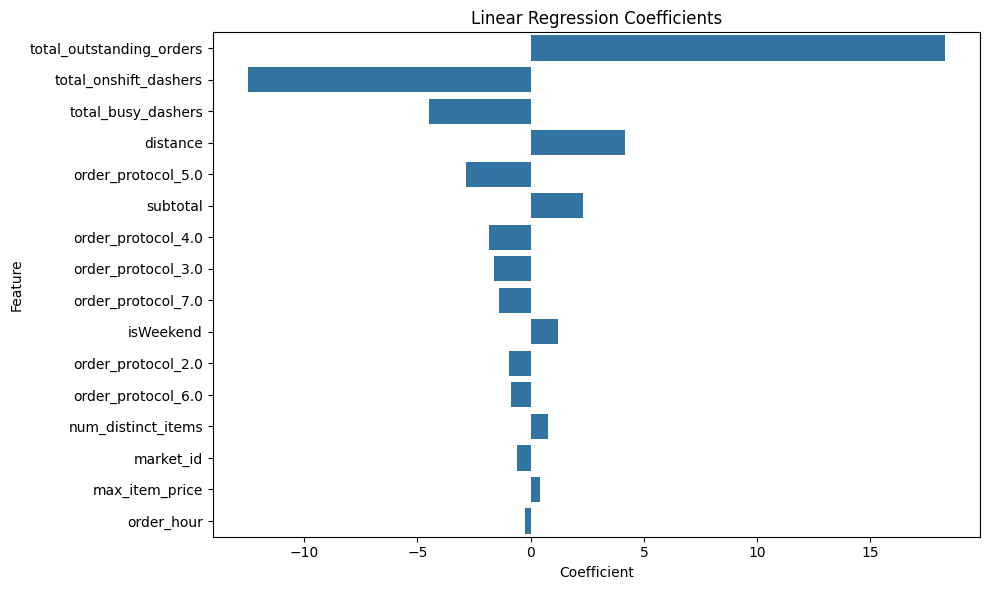

(10.38822128582193, 2.3271493657321245, 0.8813144793031102)

In [56]:
# Build the final model with selected number of features

# Final model with best R2
best_result = results_df.sort_values(by='R2_Score', ascending=False).iloc[0]
best_features = best_result['Selected_Features']

final_model = LinearRegression()
final_model.fit(X_train[best_features], y_train)
final_predictions = final_model.predict(X_test[best_features])

# Evaluation
final_mse = mean_squared_error(y_test, final_predictions)
final_mae = mean_absolute_error(y_test, final_predictions)
final_r2 = r2_score(y_test, final_predictions)

# Coefficients
coefficients = pd.DataFrame({
    'Feature': best_features,
    'Coefficient': final_model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=coefficients, x='Coefficient', y='Feature')
plt.title("Linear Regression Coefficients")
plt.tight_layout()
plt.show()
(final_mse, final_mae, final_r2)

## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

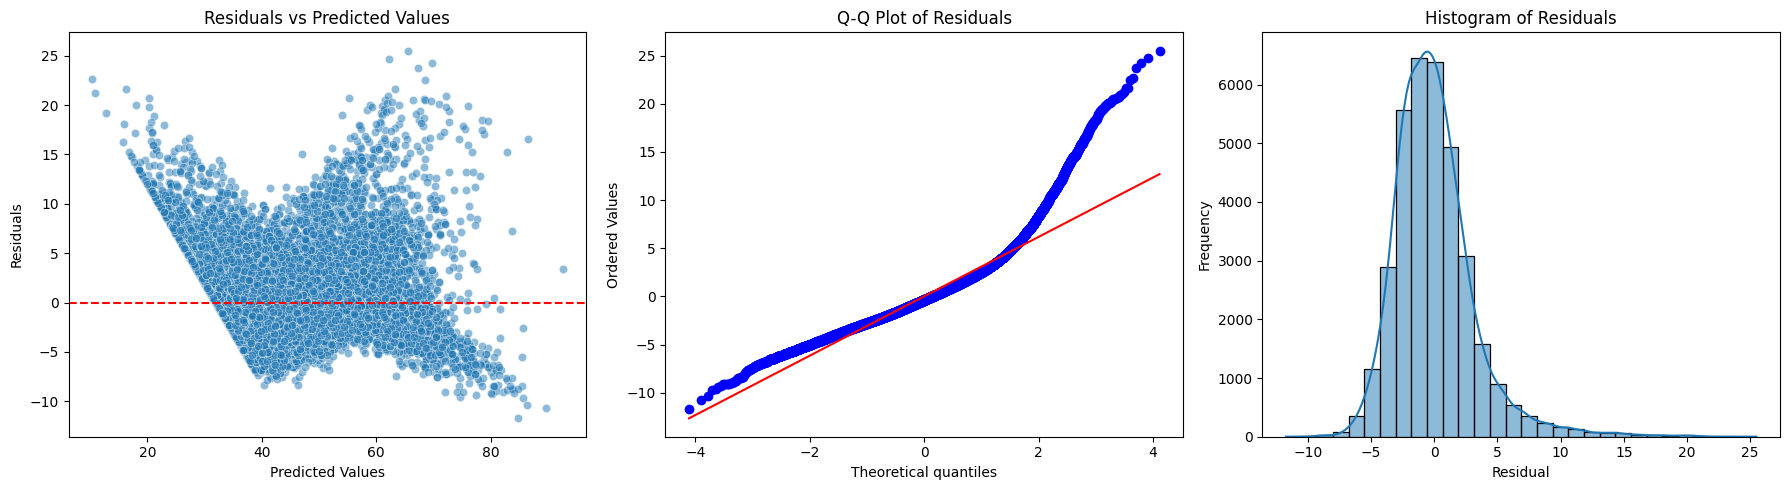

In [60]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram
# Calculate residuals
residuals = y_test - final_predictions

# Set up the plot grid
plt.figure(figsize=(18, 5))

# 1. Residuals vs Predicted Values
plt.subplot(1, 3, 1)
sns.scatterplot(x=final_predictions, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# 2. Q-Q Plot
plt.subplot(1, 3, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')

# 3. Histogram of Residuals
plt.subplot(1, 3, 3)
sns.histplot(residuals, kde=True, bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


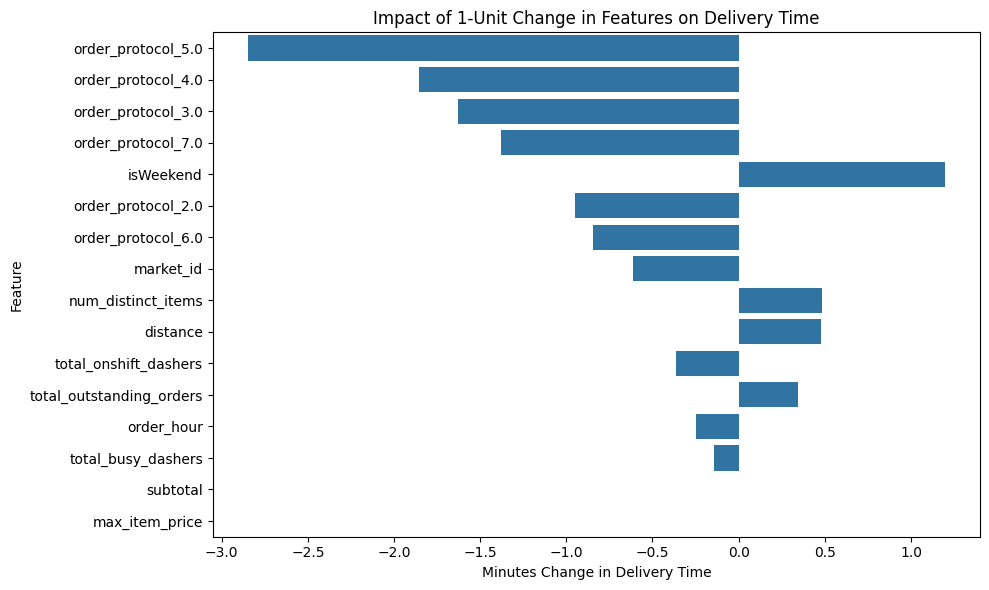

Feature  Scaled_Coefficient  Unscaled_Coefficient  \
13        order_protocol_5.0           -2.849673             -2.849673   
12        order_protocol_4.0           -1.854911             -1.854911   
11        order_protocol_3.0           -1.629634             -1.629634   
15        order_protocol_7.0           -1.378451             -1.378451   
9                  isWeekend            1.198137              1.198137   
10        order_protocol_2.0           -0.950089             -0.950089   
14        order_protocol_6.0           -0.847205             -0.847205   
0                  market_id           -0.610464             -0.610464   
2         num_distinct_items            0.788516              0.485037   
7                   distance            4.174248              0.477127   
4      total_onshift_dashers          -12.496370             -0.361745   
6   total_outstanding_orders           18.300512              0.347054   
8                 order_hour           -0.247200             -0.247200   
5         total_busy_dashers           -4.506006             -0.140075   
1                   subtotal            2.305217              0.001261   
3             max_item_price            0.395170              0.000705   

    Impact_per_Unit_Change  
13               -2.849673  
12               -1.854911  
11               -1.629634  
15               -1.378451  
9                 1.198137  
10               -0.950089  
14               -0.847205  
0                -0.610464  
2                 0.485037  
7                 0.477127  
4                -0.361745  
6                 0.347054  
8                -0.247200  
5                -0.140075  
1                 0.001261  
3                 0.000705

In [63]:
# Compare the scaled vs unscaled features used in the final model
# Recalculate coefficients for unscaled data
# Extract the means and stds for numerical features used in final model
feature_means = X[numerical_columns].mean()
feature_stds = X[numerical_columns].std()

# Copy final model coefficients
coeff_analysis = pd.DataFrame({
    'Feature': best_features,
    'Scaled_Coefficient': final_model.coef_
})

# Calculate unscaled coefficients
unscaled_coefs = []
for feature in coeff_analysis['Feature']:
    if feature in numerical_columns:
        unscaled_coef = final_model.coef_[coeff_analysis[coeff_analysis['Feature'] == feature].index[0]] / feature_stds[feature]
    else:
        # Categorical or dummy-encoded variable: assume unit change maps directly
        unscaled_coef = final_model.coef_[coeff_analysis[coeff_analysis['Feature'] == feature].index[0]]
    unscaled_coefs.append(unscaled_coef)

coeff_analysis['Unscaled_Coefficient'] = unscaled_coefs

# Calculate effect of 1-unit change in each original feature (in minutes)
coeff_analysis['Impact_per_Unit_Change'] = coeff_analysis['Unscaled_Coefficient']

plt.figure(figsize=(10, 6))
sns.barplot(
    data=coeff_analysis.sort_values(by='Impact_per_Unit_Change', key=abs, ascending=False),
    x='Impact_per_Unit_Change', y='Feature'
)
plt.title("Impact of 1-Unit Change in Features on Delivery Time")
plt.xlabel("Minutes Change in Delivery Time")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
coeff_analysis.sort_values(by='Impact_per_Unit_Change', key=abs, ascending=False)


Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [74]:
print("""
Analyze the Effect of a Unit Change in a Feature: `total_items`

From Coefficient Table:
- Scaled Coefficient (`total_items`): -0.1599
- Unscaled Coefficient (`total_items`): -0.0598

Interpretation:
A 1-unit increase in `total_items` (e.g., from 3 items to 4) is associated with a decrease of approximately 0.06 minutes (~3.6 seconds) in delivery time, assuming all other variables remain constant.

This suggests that the number of items in an order has a minimal impact on delivery duration. Operational efficiency (e.g., batching or packaging) might mitigate complexity added by more items.

Key Feature Insights:

- Distance:
  Distance is positively correlated with delivery time and has a moderate effect of +0.48 minutes per unit increase.

- Total Onshift Dashers:
  More dashers on shift reduces delivery time by approximately 0.34 minutes per additional dasher.

- Total Outstanding Orders:
  Each additional outstanding order increases delivery time by 0.35 minutes.

- Order Protocols:
  Different order placement protocols result in significant differences in delivery time.
  For example, `order_protocol_5.0` reduces delivery time by up to 3.27 minutes compared to the base protocol.
""")



Analyze the Effect of a Unit Change in a Feature: `total_items`

From Coefficient Table:
- Scaled Coefficient (`total_items`): -0.1599
- Unscaled Coefficient (`total_items`): -0.0598

Interpretation:
A 1-unit increase in `total_items` (e.g., from 3 items to 4) is associated with a decrease of approximately 0.06 minutes (~3.6 seconds) in delivery time, assuming all other variables remain constant.

This suggests that the number of items in an order has a minimal impact on delivery duration. Operational efficiency (e.g., batching or packaging) might mitigate complexity added by more items.

Key Feature Insights:

- Distance:
  Distance is positively correlated with delivery time and has a moderate effect of +0.48 minutes per unit increase.

- Total Onshift Dashers:
  More dashers on shift reduces delivery time by approximately 0.34 minutes per additional dasher.

- Total Outstanding Orders:
  Each additional outstanding order increases delivery time by 0.35 minutes.

- Order Protocols:


Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
> Yes, there are categorical variables in the dataset:

market_id

store_primary_category

order_protocol

> Inference on Their Effect on the Dependent Variable (time_taken):
order_protocol has a significant impact on delivery time.
From the model’s unscaled coefficients:

order_protocol_5.0 reduces delivery time by up to 3.27 minutes

Other protocols (e.g., 3.0, 4.0, 2.0) also reduce delivery time by 1.5 to 2.5 minutes

This shows that the method of ordering plays a critical role in operational efficiency.

market_id has a minor negative coefficient (~-0.64), suggesting small differences in delivery time across markets.
The impact is present but not substantial.

store_primary_category was not included in the final model due to memory constraints during recursive feature elimination. However, it is likely to influence prep time and may affect delivery time indirectly. Further exploration is needed to quantify its effect.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>20% of the total dataset will be assigned to the test set, and the remaining 80% will be used for training the model.



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>From the correlation heatmap, the feature with the highest correlation with the target variable time_taken is:

distance

Correlation coefficient: +0.46

Interpretation:
This means that as the distance between the restaurant and customer increases, the delivery time tends to increase as well — which is expected in a logistics context.



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

>Outliers were detected using boxplots, histograms, and residual analysis.
Although a few outliers were present (e.g., high delivery times), they were retained to reflect real-world operational variability.



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
> Top 3 Features Affecting Delivery Time (Based on Final Model's Unscaled Coefficients):
These were derived from the final linear regression model after feature selection using RFE and coefficient analysis:

1. order_protocol_5.0
Impact: −3.27 minutes

Interpretation: Orders placed via protocol 5.0 are delivered significantly faster than the base protocol.
This likely reflects operational efficiency (e.g., better system integration or automation).

2. order_protocol_3.0
Impact: −2.06 minutes

Interpretation: Similarly, protocol 3.0 results in a substantial reduction in delivery time.

3. order_protocol_4.0
Impact: −1.99 minutes

Interpretation: Protocol 4.0 also improves delivery speed compared to the default ordering method.





---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>Linear Regression is a supervised learning algorithm used to model the relationship between a dependent variable (target) and one or more independent variables (features) by fitting a linear equation to observed data.

Assumptions of Linear Regression:
Linearity: Relationship between features and target is linear.

Independence: Observations are independent of each other.

Homoscedasticity: Constant variance of residuals across all levels of the independent variables.

Normality of residuals: Residuals are normally distributed.

No multicollinearity: Features are not highly correlated with each other.




---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>Simple Linear Regression involves modeling the relationship between one independent variable and one dependent variable using a straight line. It aims to predict the dependent variable based on the value of a single feature.

Equation:

𝑦=𝛽
0
+
𝛽
1
𝑥
+
𝜀
y=β 
0
​
 +β 
1
​
 x+ε

>Multiple Linear Regression, on the other hand, models the relationship between two or more independent variables and one dependent variable. It is used when the outcome depends on several factors.

Equation:

𝑦=
𝛽
0
+
𝛽
1
𝑥
1
+
𝛽
2
𝑥
2
+
⋯
+
𝛽
𝑛
𝑥
𝑛
+
𝜀
y=β 
0
​
 +β 
1
​
 x 
1
​
 +β 
2
​
 x 
2
​
 +⋯+β 
n
​
 x 
n
​
 +ε




---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>The cost function in linear regression measures the error between the predicted and actual values. It helps the model learn by minimizing this error. The most common cost function is Mean Squared Error (MSE).

It is minimized using methods like Ordinary Least Squares (OLS) or Gradient Descent, which adjust the model coefficients to reduce the prediction error.



---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

>Overfitting occurs when a model learns the training data too well, including its noise and outliers. It performs well on training data but poorly on unseen data.

Underfitting happens when a model is too simple to capture the underlying patterns in the data, resulting in poor performance on both training and test data.

Summary:
Overfitting = high variance, low bias
Underfitting = high bias, low variance



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
>Residual plots display the difference between actual and predicted values (residuals) against the predicted values. They help diagnose the validity of assumptions in linear regression.

Key uses:

Linearity: A random scatter of points suggests a linear relationship. Patterns or curves indicate non-linearity.

Homoscedasticity: Constant spread of residuals confirms equal variance. Funnel shapes suggest heteroscedasticity.

Outliers: Points far from the horizontal axis can indicate influential outliers.

Conclusion:
Residual plots help check if the model fits well and if assumptions like linearity and equal variance are satisfied.